# COGS 108 - EDA Checkpoint

# Names

- Chance Kang
- Lobna Kebir
- Brian Lu
- Sia Sheth
- Aaron Wixson

<a id='research_question'></a>
# Research Question

In a global context, out of the following economical factors related to people’s economic security, which one most strongly influences happiness? 

 * GDP (Gross domestic product, current prices) 
 * Investment (Total investment)
 * Savings (Gross national savings) 
 * CPI (Inflation, average consumer prices)
 * VIGS (Volume of imports of goods and services) 
 * VIG (Volume of Imports of goods)
 * VEGS (Volume of exports of goods and services) 
 * VEG (Volume of exports of goods)
 * Population
 * Revenue (General government revenue) 
 * Expenditure (General government total expenditure)
 * Debt (General government gross debt)
 * Balance (Current account balance) 
 * Unemployment 

Here, happiness is defined by the [World Happiness Report](https://worldhappiness.report/about/), and they use factors such as social support, life expectancy at birth, freedom of choice, confidence in government, and perception of corruption to determine happiness. An in depth econometric analysis of the impact of money categories on happiness, building upon and updating current research.


# Setup

In [47]:
#pip install geopandas

In [48]:
pip install statsmodels

In [118]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
import geopandas
import folium
from IPython.display import display, HTML
import warnings
import patsy
from IPython.display import Image
import statsmodels.api as sm
from sklearn.linear_model import Lasso

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None #suppressing SettingWithCopyWarning: used to not set a value

# Data Cleaning

In [50]:
years = ['2012','2013','2014','2015','2016','2017',
'2018','2019','2020','2021','2022'] # years to be observed

#reading csv
weo = pd.read_csv('WEO.csv')
happiness = pd.read_csv('Happiness.csv')

#using set to extract common names
weo_country = set(weo["Country"].unique().tolist())
happiness_country = set(happiness["Country name"].unique().tolist())

common_country = weo_country & happiness_country
weo_not = weo_country - common_country
happiness_not = happiness_country - common_country

print(sorted(happiness_not))
print(sorted(weo_not))

['Congo (Brazzaville)', 'Congo (Kinshasa)', 'Cuba', 'Czechia', 'Gambia', 'Hong Kong S.A.R. of China', 'Iran', 'Ivory Coast', 'Kyrgyzstan', 'Laos', 'Slovakia', 'Somaliland region', 'South Korea', 'State of Palestine', 'Syria', 'Turkiye']
['Andorra', 'Antigua and Barbuda', 'Aruba', 'Barbados', 'Brunei Darussalam', 'Cabo Verde', 'Czech Republic', "CÙte d'Ivoire", 'Democratic Republic of the Congo', 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Fiji', 'Grenada', 'Guinea-Bissau', 'Hong Kong SAR', 'Islamic Republic of Iran', 'Kiribati', 'Korea', 'Kyrgyz Republic', 'Lao P.D.R.', 'Macao SAR', 'Marshall Islands', 'Micronesia', 'Nauru', 'Palau', 'Papua New Guinea', 'Puerto Rico', 'Republic of Congo', 'Samoa', 'San Marino', 'Seychelles', 'Slovak Republic', 'Solomon Islands', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'S„o TomÈ and PrÌncipe', 'The Bahamas', 'The Gambia', 'Timor-Leste', 'Tonga', 'Tuvalu', 'T¸rkiye', 'Vanuatu', 'West Bank and Gaza']


Above is the lists of countries that are not common from both sets of data. 
First is from the Happiness Report and second is from the WEO.

Since some country names are reported different in each of the organizations, we manually matched such countries: 

* Congo (Brazzaville) -> Republic of Congo
* Congo (Kinshasa) -> Democratic Republic of the Congo
* Czechia -> Czech Republic
* Hong Kong S.A.R of China -> Hong Kong SAR
* Iran -> Iran (from Islamic Republic of Iran)
* Kyrgyzstan -> Kyrgyzstan (from Kyrgyz Republic)
* Laos -> Laos (from Lao P.D.R)
* Slovakia -> Slovakia (from Slovak Republic)
* South Korea -> South Korea (from Korea)
* Turkiye -> Turkiye (from T¸rkiye)
* Cuba, Gambia, Ivory Coast, Somaliland region, State of Palestine, Syria - > removed

In [51]:
#replacing left to right
happiness['Country name'].replace(['Congo (Brazzaville)', 'Congo (Kinshasa)', 'Czechia', 'Hong Kong S.A.R. of China'], 
            ['Republic of Congo', 'Democratic Republic of the Congo', 'Czech Republic', 'Hong Kong SAR'], inplace = True)
#replacing right to (from [name])
weo['Country'].replace(['Islamic Republic of Iran', 'Kyrgyz Republic', 'Lao P.D.R.', 'Slovak Republic', 'Korea', 'T¸rkiye'],
                 ['Iran', 'Kyrgyzstan', 'Laos', 'Slovakia', 'South Korea', 'Turkiye'], inplace = True)

#checking
weo_country = set(weo["Country"].unique().tolist())
happiness_country = set(happiness["Country name"].unique().tolist())
common_country = list(sorted(weo_country & happiness_country))
print(common_country)

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembou

The above is the list of countries that are common from both of the lists. 

Note that these countries may not have all entries for variables we are observing and are subjected to be excluded in the later process.

From here on, a single data frame: `data` containing entries from both dataframe will be constructed.

In [52]:
#creating unified data frame: data

#dropping other variables
data = happiness[['Country name', 'year', 'Life Ladder', 'Positive affect', 'Negative affect']] 
#only keeping those after 2012
data.drop(data[data['year'] < 2012].index, inplace = True) 
#numerical year value is no longer needed / potential to influence other num vals
data['year'] = data['year'].apply(str) 

#adding weo variables to data
weo_vars = weo['Subject Descriptor'].unique().tolist()
for var in weo_vars:
    data[var] = np.nan

weo_og = weo.copy()
#copying of weo values to data
weo = weo.drop(columns = ['Subject Notes','Units', 'Scale' , 'Country/Series-specific Notes', 'Estimates Start After'])
index = data.index #optain all indices of data
for i in index:
    country = data.loc[i,'Country name'] #get country name from index i
    year = data.loc[i,'year'] #year from index i
    for var in weo_vars: 
        if country in common_country and year in years:
            #accessing values of variables from weo
            temp = weo.loc[(weo['Country'] == country)&(weo['Subject Descriptor'] == var) , year] 
            if temp.empty == False:
                #writing the values of variables from weo to data
                data.at[i,var] = temp[temp.index[0]]

The `data` variable now contains all information from two tables from the years 2012 - 2022 with common countries. 

Some entries of WEO report is missing and are indicated with `string` object `'na'`. 

The following is the cleaning of all invalid inputs.

In [53]:
#'na' to 'NaN' along with changing values to float of WEO variable columns
cols = data.columns.drop(['Country name', 'year'])
data[cols] = data[cols].replace(',','', regex=True)
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

#dataNA: with missing data for EDA
dataNa = data.copy()

#dropping nans
data = data.dropna()

#index reset
data.reset_index(drop=True, inplace=True)

#column renaming
data.columns = [ 'Country', 'Year', 'LifeLadder', 'PositiveAffect' , 'NegativeAffect',
              'GDP', 'Investment','Savings','CPI','VIGS','VIG','VEGS', 
              'VEG', 'Population', 'Revenue','Expenditure','Debt','Balance','Unemployment']
dataNa.columns = [ 'Country', 'Year', 'LifeLadder', 'PositiveAffect' , 'NegativeAffect',
              'GDP', 'Investment','Savings','CPI','VIGS','VIG','VEGS', 
              'VEG', 'Population', 'Revenue','Expenditure','Debt','Balance','Unemployment']

Since the data sets we are using only give real GDP, we can create a column using population to find GDP per capita 

In [54]:
data['GDP per Capita'] = data['GDP']/data['Population']

In [55]:
data.sample(5)

,Country,Year,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,GDP per Capita
13,Algeria,2016,5.3410,0.5650,0.3770,160.0340,50.7780,34.2210,183.6990,-1.2370,-1.8420,9.6120,7.8830,40.8360,28.6140,41.9950,20.4380,-16.5420,10.4980,3.9189
385,Indonesia,2015,5.0430,0.7960,0.2740,860.7410,34.0630,32.0280,90.0830,-8.3380,-8.3380,-3.5080,-2.3640,255.5880,14.8750,17.4780,27.0130,-2.0350,6.1800,3.3677
414,Ireland,2022,6.8700,0.7380,0.2340,529.6610,28.8790,37.6800,112.0000,18.9540,23.3650,14.9980,22.5540,5.1340,23.3120,22.1110,45.1900,8.8010,4.5000,103.1673
82,Belgium,2013,7.1040,0.7380,0.2170,521.7990,22.4280,23.3830,98.8980,0.7340,0.7340,2.6200,2.6200,11.1380,52.9870,56.1160,105.4860,0.9550,8.5750,46.8485
292,Finland,2014,7.3850,0.7660,0.1990,274.9340,21.8940,20.5630,100.1560,-0.8970,-0.2700,-1.9520,-2.7000,5.4510,54.2860,57.2740,64.4570,-1.3320,8.8250,50.4374


In [56]:
data.describe()

,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,GDP per Capita
count,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000
mean,6.0238,0.6737,0.2614,862.8066,24.2339,23.5156,363779138399.5905,3.6122,3.3637,3.7951,3.4837,51.4272,32.1236,34.9665,59.5123,-0.7853,8.2735,22.0024
std,0.8783,0.1031,0.0778,2561.3974,6.6963,8.0097,3428096851655.6704,9.3361,9.1360,9.9977,8.9143,149.6611,11.4016,10.9687,37.7060,6.6025,5.6352,22.9267
min,3.5590,0.2970,0.0830,1.7840,5.1110,-3.9570,40.1940,-50.0610,-50.0610,-43.0780,-43.0780,0.3200,5.1170,9.7610,0.0550,-43.8250,0.7000,1.1319
25%,5.3810,0.5940,0.2040,46.6070,20.0300,18.2820,99.3250,-0.1270,-0.6700,0.2600,-0.5190,5.1280,23.6330,27.0660,36.6290,-4.0920,4.7970,4.7731
50%,6.0070,0.6980,0.2530,215.6810,23.2720,22.8730,104.9090,3.8680,3.5640,3.7070,3.1800,10.5540,31.9370,35.4290,51.9290,-1.2160,6.6170,12.4249
75%,6.6480,0.7530,0.3080,535.3280,26.6000,27.8660,131.7980,8.0940,7.6400,7.8110,6.8880,46.3000,40.3420,42.6570,75.9270,2.6370,9.8350,33.6279
max,7.8890,0.8840,0.5520,25464.4800,56.4170,58.6970,41964222399270.1016,48.7440,42.5020,84.1090,64.4110,1412.6000,71.9750,69.9200,261.2890,45.4620,35.3000,127.6589


# Data Analysis & Results (EDA)

In [57]:
'''
converting Year to int
DO CONVERT BACK TO STRING WHEN YEAR DOES NOT NEED TO BE INT
'''
data["Year"] = data["Year"].astype(int)

### Function Definition
`consec_years(df,year1,year2)`
* Input: `df` as dataframe, `year1`,`year2` as int
* Output: `df_r` as dataframe
* Description: returns a copy of dataframe that includes only the countries that have consecutive years of data in range [`year1`,`year2`]

In [58]:
# written by Chance Kang for returning subset of dataframe with countries that have consecutive years data
def consec_years(df, year1, year2):
    #containing countries with consecutive data
    curr_country = set(data[data["Year"] == year1].Country.unique().tolist())
    #increment year1
    while year1 <= year2:
        #update interscetion with current year's list
        curr_country = curr_country and set(data[data["Year"] == year1].Country.unique())
        year1+=1
    #extract names of countries to remove
    to_remove = list(set(data["Country"].unique().tolist()) - curr_country)
    #copy to preserve
    df_r = df.copy()
    #drop with names
    df_r = df_r.drop(df_r[df_r.Country.isin(to_remove)].index)
    return df_r

### NaN Analysis


In [59]:
#dataNa for NaN data analysis
print(dataNa.shape)
#data for cleaned
print(data.shape)

(1487, 19)
(957, 20)


The shape of `dataNa` shows that we have dropped about 500 of observations from missing data. Following will analyze the missing data. 

<AxesSubplot: >

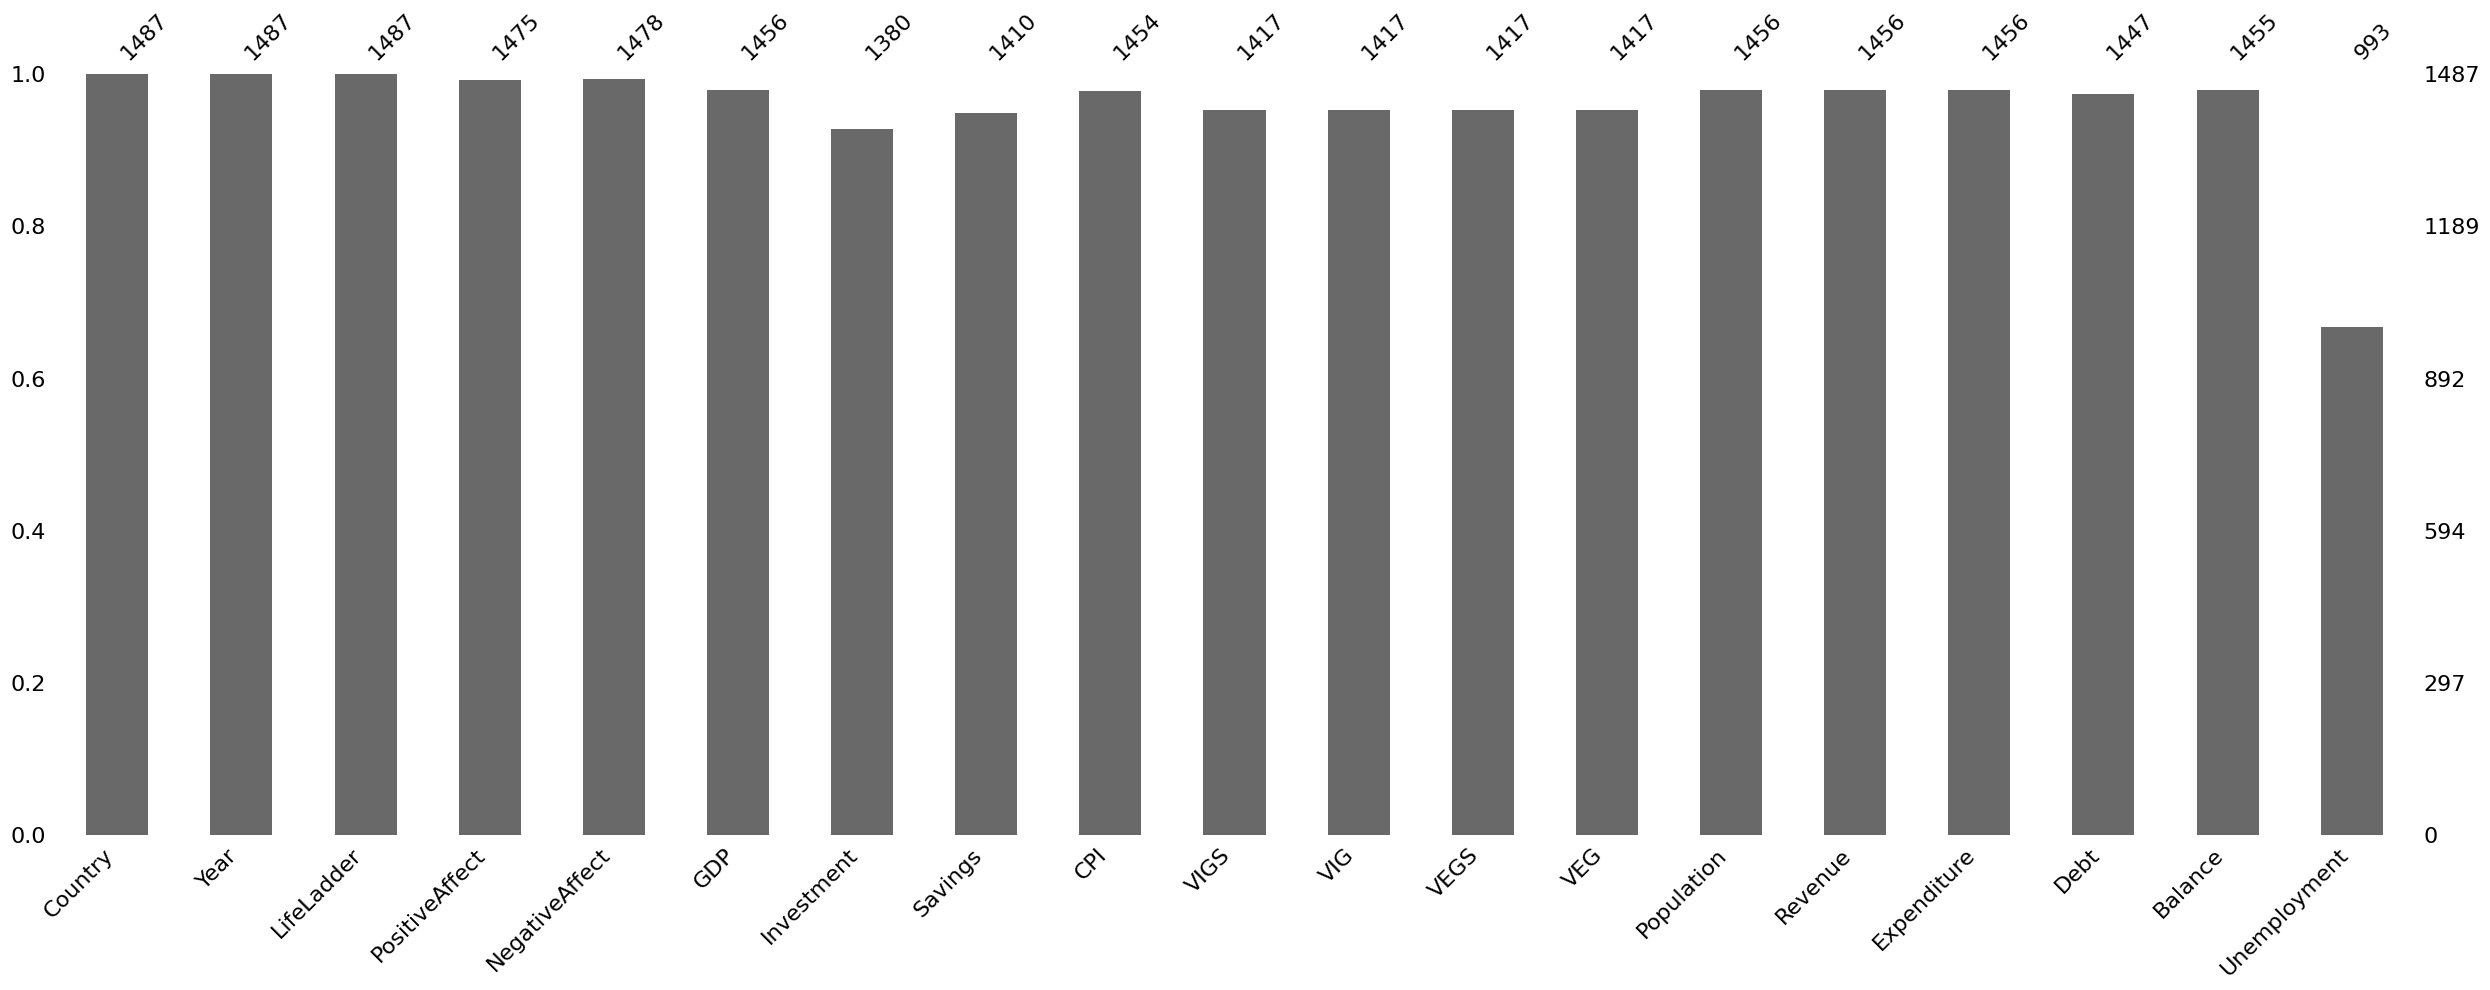

In [60]:
msno.bar(dataNa)

`Unemployment` variable reports relatively high number of missing values.

<AxesSubplot: >

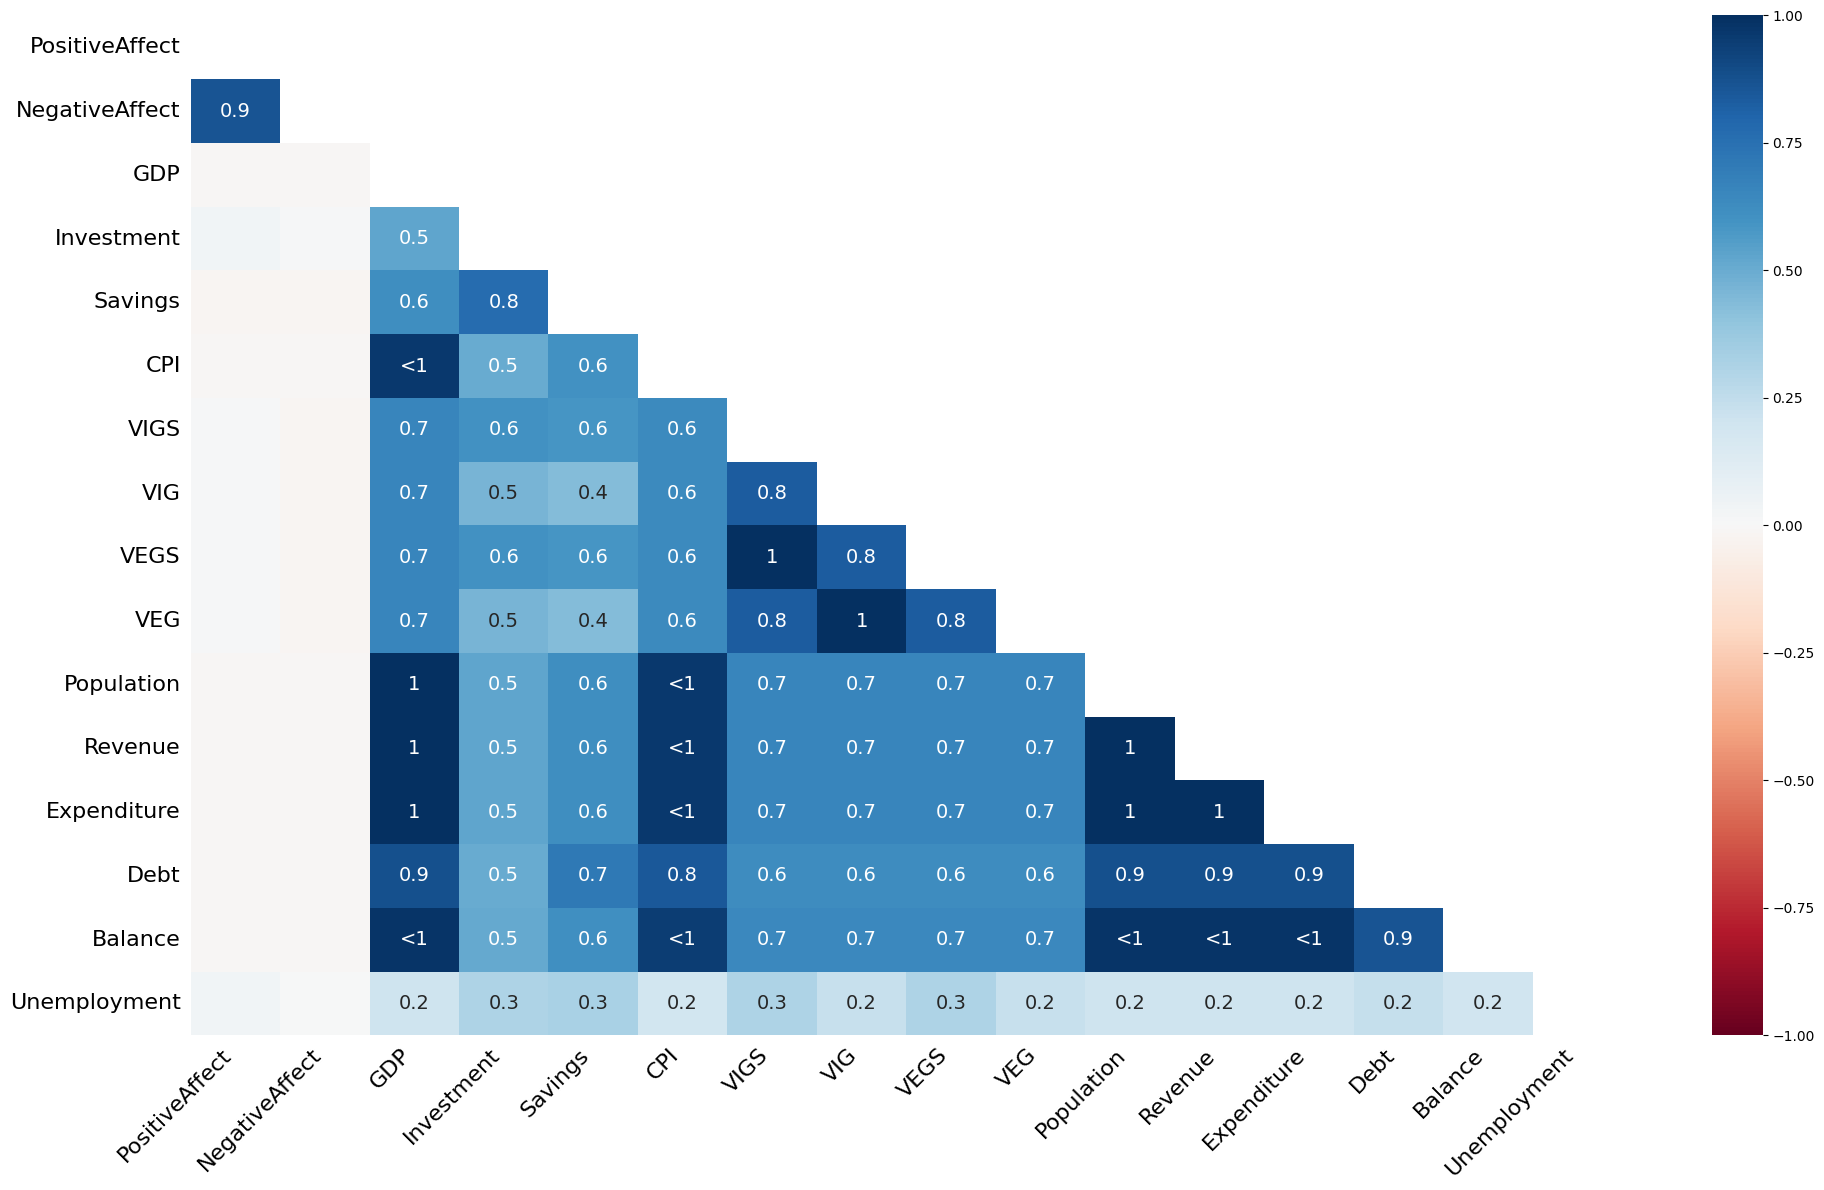

In [61]:
msno.heatmap(dataNa)

The heatmap shows high correlation of missing data from the following varialbes: `GDP`, `Balance`, `Debt`, `Expenditure`, `Revenue`, `Population`. The others are recorded in percent of `GDP` hence the high correlation. 

In [62]:
unemp_Na = dataNa[dataNa['Unemployment'].isnull()]
print(unemp_Na.Country.unique())
print(unemp_Na.Year.unique())

['Afghanistan' 'Algeria' 'Angola' 'Bangladesh' 'Benin' 'Botswana'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Central African Republic'
 'Chad' 'Comoros' 'Republic of Congo' 'Democratic Republic of the Congo'
 'Eswatini' 'Ethiopia' 'Gabon' 'Gambia' 'Ghana' 'Guatemala' 'Guinea'
 'Haiti' 'India' 'Iraq' 'Ivory Coast' 'Jamaica' 'Kenya' 'Kosovo' 'Laos'
 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Madagascar' 'Malawi' 'Maldives'
 'Mali' 'Mauritania' 'Montenegro' 'Mozambique' 'Myanmar' 'Namibia' 'Nepal'
 'Niger' 'Nigeria' 'Qatar' 'Rwanda' 'Saudi Arabia' 'Senegal'
 'Sierra Leone' 'Somalia' 'Somaliland region' 'South Sudan'
 'State of Palestine' 'Syria' 'Tajikistan' 'Tanzania' 'Togo'
 'Trinidad and Tobago' 'Tunisia' 'Turkmenistan' 'Uganda'
 'United Arab Emirates' 'Venezuela' 'Yemen' 'Zambia' 'Zimbabwe']
['2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2021' '2022'
 '2020']


In [63]:
ie_Na = dataNa[(dataNa['Population'].isnull()) | (dataNa['Revenue'].isnull()) | (dataNa['Expenditure'].isnull()) 
               | (dataNa['Debt'].isnull()) | (dataNa['Balance'].isnull()) | (dataNa['GDP'].isnull())]
print(ie_Na.Country.unique())
print(ie_Na.Year.unique())

['Afghanistan' 'Bulgaria' 'Gambia' 'Ivory Coast' 'Lebanon' 'Libya'
 'Somalia' 'Somaliland region' 'State of Palestine' 'Syria']
['2021' '2022' '2015' '2017' '2018' '2019' '2013' '2014' '2016' '2020'
 '2012']


The missing values for the dataset exists for all observed years. 

However, the countries with missing data seems to show some overlap with majority of countries with missing data on economic factors also showing up in the list of countries with missing data for `Unemployment` variable. At a glance, the countries from the first and second list are often considered developing countries, yet data from some developing countries such as `Vietnam` does exist. The considerable number of countries from the second list have experienced and is still experiencing national conflicts.

WEO reports, [" All of the data that can be released to the public are already incorporated into the WEO online database. Missing data in the table downloads and CSV files are indeed unavailable and not a result of a technical issue ... Some indicators are not included in the online database and are reserved for IMF staff research (IMF working papers, IMF staff reports, etc.)".](https://www.imf.org/en/Publications/WEO/frequently-asked-questions) Hence, the data itself is more likely that it is not availabe for the public or missing from continous conflicts and lack of statistical capacity than being biased.

## Descriptive and Exploratory Analysis

In [64]:
data.shape

(957, 20)

In [65]:
data.describe()

,Year,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,GDP per Capita
count,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000,957.0000
mean,2016.8558,6.0238,0.6737,0.2614,862.8066,24.2339,23.5156,363779138399.5905,3.6122,3.3637,3.7951,3.4837,51.4272,32.1236,34.9665,59.5123,-0.7853,8.2735,22.0024
std,3.1126,0.8783,0.1031,0.0778,2561.3974,6.6963,8.0097,3428096851655.6704,9.3361,9.1360,9.9977,8.9143,149.6611,11.4016,10.9687,37.7060,6.6025,5.6352,22.9267
min,2012.0000,3.5590,0.2970,0.0830,1.7840,5.1110,-3.9570,40.1940,-50.0610,-50.0610,-43.0780,-43.0780,0.3200,5.1170,9.7610,0.0550,-43.8250,0.7000,1.1319
25%,2014.0000,5.3810,0.5940,0.2040,46.6070,20.0300,18.2820,99.3250,-0.1270,-0.6700,0.2600,-0.5190,5.1280,23.6330,27.0660,36.6290,-4.0920,4.7970,4.7731
50%,2017.0000,6.0070,0.6980,0.2530,215.6810,23.2720,22.8730,104.9090,3.8680,3.5640,3.7070,3.1800,10.5540,31.9370,35.4290,51.9290,-1.2160,6.6170,12.4249
75%,2019.0000,6.6480,0.7530,0.3080,535.3280,26.6000,27.8660,131.7980,8.0940,7.6400,7.8110,6.8880,46.3000,40.3420,42.6570,75.9270,2.6370,9.8350,33.6279
max,2022.0000,7.8890,0.8840,0.5520,25464.4800,56.4170,58.6970,41964222399270.1016,48.7440,42.5020,84.1090,64.4110,1412.6000,71.9750,69.9200,261.2890,45.4620,35.3000,127.6589


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         957 non-null    object 
 1   Year            957 non-null    int32  
 2   LifeLadder      957 non-null    float64
 3   PositiveAffect  957 non-null    float64
 4   NegativeAffect  957 non-null    float64
 5   GDP             957 non-null    float64
 6   Investment      957 non-null    float64
 7   Savings         957 non-null    float64
 8   CPI             957 non-null    float64
 9   VIGS            957 non-null    float64
 10  VIG             957 non-null    float64
 11  VEGS            957 non-null    float64
 12  VEG             957 non-null    float64
 13  Population      957 non-null    float64
 14  Revenue         957 non-null    float64
 15  Expenditure     957 non-null    float64
 16  Debt            957 non-null    float64
 17  Balance         957 non-null    flo

`data` has 957 entries with 19 variables. 

The two variables: `Country` and `Year` are in `str` format (`Year` was changed to `int` for EDA only). Rest of the variables are in `float`. 

In [67]:
data.Country.unique()

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Belarus', 'Belgium', 'Belize',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Honduras',
       'Hong Kong SAR', 'Hungary', 'Iceland', 'Indonesia', 'Iran',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Luxembourg', 'Malaysia', 'Malta', 'Mauritius', 'Mexico',
       'Moldova', 'Mongolia', 'Morocco', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Paraguay',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Saudi Arabia', 'Serbia', 'S

In [68]:
data.Country.unique().size

96

Above is the final list of countries that are not removed from data cleaning.

As a reminder variables:
1. `Investment`, `Savings`, `Revenue`, `Expenditure`, `Debt` are recorded with percent of GDP
2. `GDP` is in dollars of billions
3. `Population` is in persons of millions
4. Import/Exports are recorded in percentage change (0 means no change from previous year)

The values in `data` will be kept the same. If needed `GDP` and the mentioned variables will be multiplied out, and `GDP` will be analyzed as `log(GDP)`.

<AxesSubplot: >

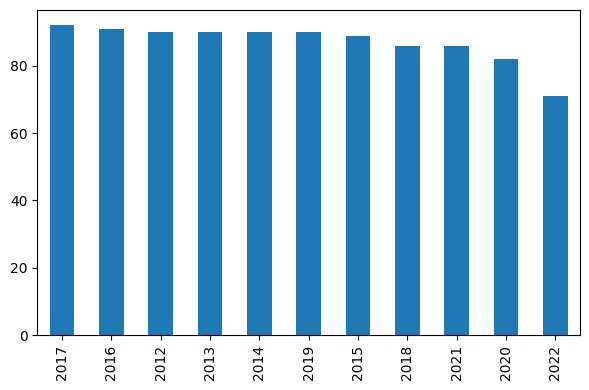

In [69]:
plt.rcParams["figure.figsize"] = [6.00, 4.00]

data["Year"].value_counts().plot(kind = 'bar')

We expected more values for more recent years but there are more entries for years 2012-13, 16-17, than 2020-2022.

<AxesSubplot: >

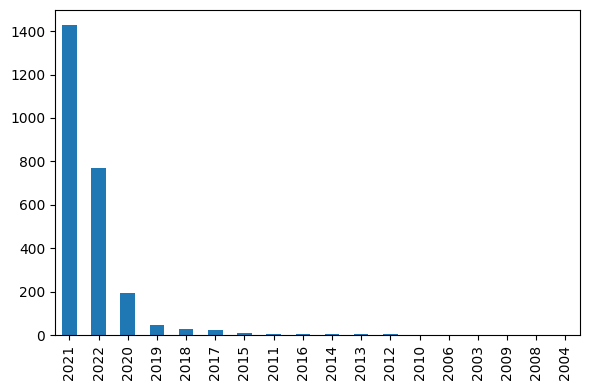

In [70]:
weo_og["Estimates Start After"].value_counts().plot(kind = 'bar')

`Estimates Start After` is from the raw WEO database. There are high counts of estimates starting from 2021 and 2022. WEO reported [due to the high level of uncertainty in current global economic conditions at the time](https://www.imf.org/en/Publications/WEO/frequently-asked-questions#2q7) few data was published for April 2020 WEO. Hence, dataset contains less entries for years 2020~2021.

### Univariate Approaches:

Since our data spans across multibple years and countries it might be usefull to first analyze the mean values acrross our 2012-2022 time frame. To do this we can group by country and analyze as follows;

In [71]:
# log linearization for better graphs
data['logCPI'] = np.log(data['CPI'])
data_span = data.groupby('Country', as_index=False)['LifeLadder', 'PositiveAffect', 'NegativeAffect', 
                        'GDP', 'Investment', 'Savings', 'CPI', 'VIGS', 'VIG',
                        'VEGS', 'VEG', 'Population', 'Revenue', 'Expenditure',
                        'Debt', 'Balance', 'Unemployment', 'logCPI', 'GDP per Capita'].mean()
data_span.head()

,Country,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,logCPI,GDP per Capita
0,Albania,4.9513,0.5604,0.3015,14.2904,25.9115,16.1819,104.0132,3.0425,3.4888,6.6155,7.7284,2.8824,26.5547,30.1748,70.6989,-8.3985,13.7041,4.6425,4.9596
1,Algeria,5.3897,0.5493,0.2635,182.8237,45.9413,37.9438,184.3242,0.5573,1.3777,-0.7590,-0.7283,40.8613,33.2107,41.6675,24.8460,-7.9930,11.1483,5.2113,4.5060
2,Argentina,6.1628,0.7236,0.3046,541.7806,17.3127,15.7033,487.5564,2.2187,1.9593,0.3783,0.7122,44.2817,33.8454,38.9841,70.6988,-1.6092,8.6019,5.7395,12.2727
3,Armenia,4.7244,0.5247,0.4542,12.5417,20.3448,15.4935,211.7200,11.5738,10.0691,19.1772,17.5966,2.9753,22.3942,25.3657,47.1899,-4.8511,17.0500,5.3514,4.2176
4,Australia,7.2145,0.7329,0.2164,1448.5955,24.7535,23.2831,111.8023,1.9154,2.8315,3.1582,3.5805,24.6414,34.7907,38.4396,42.7717,-1.5034,5.4613,4.7147,58.8534


Also, because we are working with 96 contries there is a lot of data to compare, to get a holistic intial view of the data we can analize the top 10 countires with the highest life ladder (happiest) vs the bottom 10 countires with the lowest life ladder (saddest). Thus we will create 3 sorted sub-data sets, a mean ranked spaning all collected years, a 2012 ranked, and finally a 2022 ranked 

In [72]:
# Sort average data by happiness rank
data_span_ranked = data_span.sort_values(by=['LifeLadder'], ascending=False)
data_span_ranked = pd.concat([data_span_ranked.head(10), data_span_ranked.tail(10)])

# Multiply out GDP percentages since some of data is recorded as percentage of GDP (as mentioned above)
data_span_ranked['Investment'] = (data_span_ranked['Investment']/100)*data_span_ranked['GDP']
data_span_ranked['Savings'] = (data_span_ranked['Savings']/100)*data_span_ranked['GDP']
data_span_ranked['Revenue'] = (data_span_ranked['Revenue']/100)*data_span_ranked['GDP']
data_span_ranked['Expenditure'] = (data_span_ranked['Expenditure']/100)*data_span_ranked['GDP']
data_span_ranked['Debt'] = (data_span_ranked['Debt']/100)*data_span_ranked['GDP']

data_span_ranked.head()

,Country,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,logCPI,GDP per Capita
30,Finland,7.6542,0.7494,0.1879,266.2957,63.3205,59.8485,102.4885,2.5516,2.0472,1.8217,1.0141,5.4890,141.5074,147.4097,178.4150,-1.3037,8.0575,4.6289,48.5080
24,Denmark,7.5804,0.7870,0.2085,347.1982,75.2568,104.4445,102.2818,3.3465,2.9931,3.2619,3.5707,5.7318,185.6822,183.1612,133.2701,8.4066,5.9501,4.6270,60.5378
38,Iceland,7.5220,0.8014,0.1651,21.5030,4.3195,4.8928,161.9454,6.0612,6.4218,3.7924,1.6764,0.3453,9.6693,10.0026,19.0203,2.6661,4.8556,5.0827,61.8464
64,Norway,7.4733,0.7878,0.2069,446.1101,120.4988,166.8086,116.3044,1.8653,1.6597,2.1765,1.3836,5.2708,248.4530,212.4256,169.2992,10.3714,4.0237,4.7532,84.6902
84,Switzerland,7.4697,0.7553,0.1852,728.3359,190.7592,238.1644,100.8263,0.9496,-0.0300,2.1180,1.5669,8.4124,241.8330,240.9772,300.7175,6.5086,2.8720,4.6133,86.5434


Here we note that on average Finland is the happiest and Egypt is the unhappiest. 

In [73]:
# Sort 2012 data by happiness rank
data_2012_ranked = data[data['Year'] == 2012].sort_values(by=['LifeLadder'], ascending=False)

# Multiply out GDP percentages since some of data is recorded as percentage of GDP (as mentioned above)
data_2012_ranked['Investment'] = (data_2012_ranked['Investment']/100)*data_2012_ranked['GDP']
data_2012_ranked['Savings'] = (data_2012_ranked['Savings']/100)*data_2012_ranked['GDP']
data_2012_ranked['Revenue'] = (data_2012_ranked['Revenue']/100)*data_2012_ranked['GDP']
data_2012_ranked['Expenditure'] = (data_2012_ranked['Expenditure']/100)*data_2012_ranked['GDP']
data_2012_ranked['Debt'] = (data_2012_ranked['Debt']/100)*data_2012_ranked['GDP']

data_2012_ranked.head()

,Country,Year,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,...,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,GDP per Capita,logCPI
835,Switzerland,2012,7.7760,0.7930,0.1760,686.3730,182.1497,243.0996,101.1460,-2.1080,...,1.0440,-2.2890,7.9550,218.9049,217.2920,292.2576,8.8800,2.9050,86.2820,4.6166
629,Norway,2012,7.6780,0.7980,0.2130,512.7770,132.6093,202.0598,101.9910,2.9350,...,2.0560,-0.6950,5.0110,287.5653,217.4174,158.4891,13.5330,3.2940,102.3303,4.6249
373,Iceland,2012,7.5910,0.8170,0.1570,14.7520,2.3627,1.8346,140.7250,4.6040,...,3.5980,3.4400,0.3200,6.6543,7.0414,19.7566,-3.5790,6.6170,46.1000,4.9468
824,Sweden,2012,7.5600,0.7960,0.1700,552.4840,124.8117,155.0270,98.6580,0.1220,...,0.5580,-0.5190,9.5560,269.5017,275.7171,207.1760,5.4690,8.1500,57.8154,4.5917
224,Denmark,2012,7.5200,0.7830,0.2090,327.1490,63.6828,84.2343,98.9080,2.7090,...,1.1620,-0.5840,5.5810,178.1784,189.5992,146.8703,6.2820,7.7920,58.6183,4.5942


In [74]:
# Sort 2022 data by happiness rank
data_2022_ranked = data[data['Year'] == 2022].sort_values(by=['LifeLadder'], ascending=False)

# Multiply out GDP percentages since some of data is recorded as percentage of GDP (as mentioned above)
data_2022_ranked['Investment'] = (data_2022_ranked['Investment']/100)*data_2022_ranked['GDP']
data_2022_ranked['Savings'] = (data_2022_ranked['Savings']/100)*data_2022_ranked['GDP']
data_2022_ranked['Revenue'] = (data_2022_ranked['Revenue']/100)*data_2022_ranked['GDP']
data_2022_ranked['Expenditure'] = (data_2022_ranked['Expenditure']/100)*data_2022_ranked['GDP']
data_2022_ranked['Debt'] = (data_2022_ranked['Debt']/100)*data_2022_ranked['GDP']

data_2022_ranked.head()

,Country,Year,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,...,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,GDP per Capita,logCPI
300,Finland,2022,7.7290,0.7410,0.1910,281.0470,76.6528,64.7279,113.7300,7.7460,...,1.6610,0.9160,5.5480,146.6672,151.9059,210.2428,-4.2420,6.7750,50.6574,4.7338
425,Israel,2022,7.6620,0.5830,0.1830,522.5300,137.4254,156.5134,100.0080,11.6990,...,7.9890,3.4710,9.5510,193.3988,192.6986,318.3828,3.6530,3.7580,54.7095,4.6053
234,Denmark,2022,7.5450,0.7870,0.2050,390.6770,96.2589,146.3398,113.8250,3.7120,...,7.5850,5.4340,5.8730,201.8511,192.1701,115.8670,12.8190,4.4670,66.5209,4.7347
381,Iceland,2022,7.4490,0.7680,0.1780,27.8420,6.2959,5.8669,193.0750,19.6890,...,20.6000,1.3620,0.3760,11.6371,12.8329,19.1347,-1.5410,3.7500,74.0479,5.2631
834,Sweden,2022,7.4310,0.7500,0.1630,585.9390,164.8539,189.7974,119.3980,8.6540,...,6.2780,2.8120,10.5220,278.1042,274.1784,185.6606,4.2570,7.4670,55.6870,4.7825


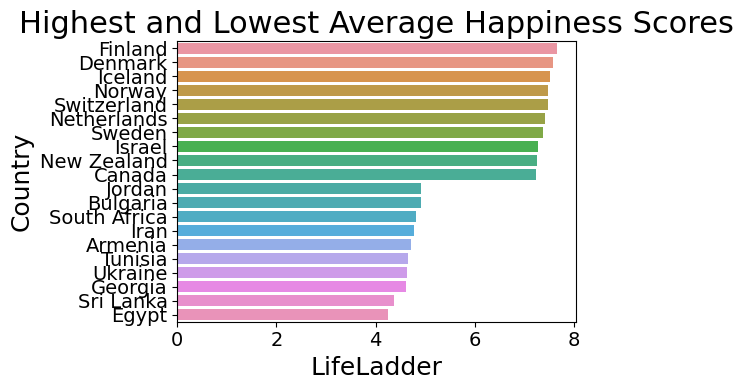

In [75]:
sns.barplot(x='LifeLadder', y='Country', data=data_span_ranked)
plt.xlabel('LifeLadder', fontsize=18);
plt.ylabel('Country', fontsize=18);
plt.title('Highest and Lowest Average Happiness Scores', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

For each of the economic indicies we will explore their values with the highest and lowest countries. 

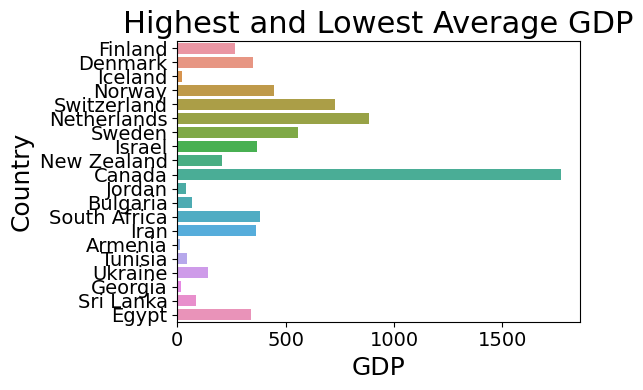

In [76]:
sns.barplot(x='GDP', y='Country', data=data_span_ranked)
plt.xlabel('GDP', fontsize=18);
plt.ylabel('Country', fontsize=18);
plt.title('Highest and Lowest Average GDP', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

Note that here GDP is not necessarily showing a corelation with the happiest countries, but before we can make that conclusion we must check the GDP per capita as the population may be disproportianatly helping larger countries.  

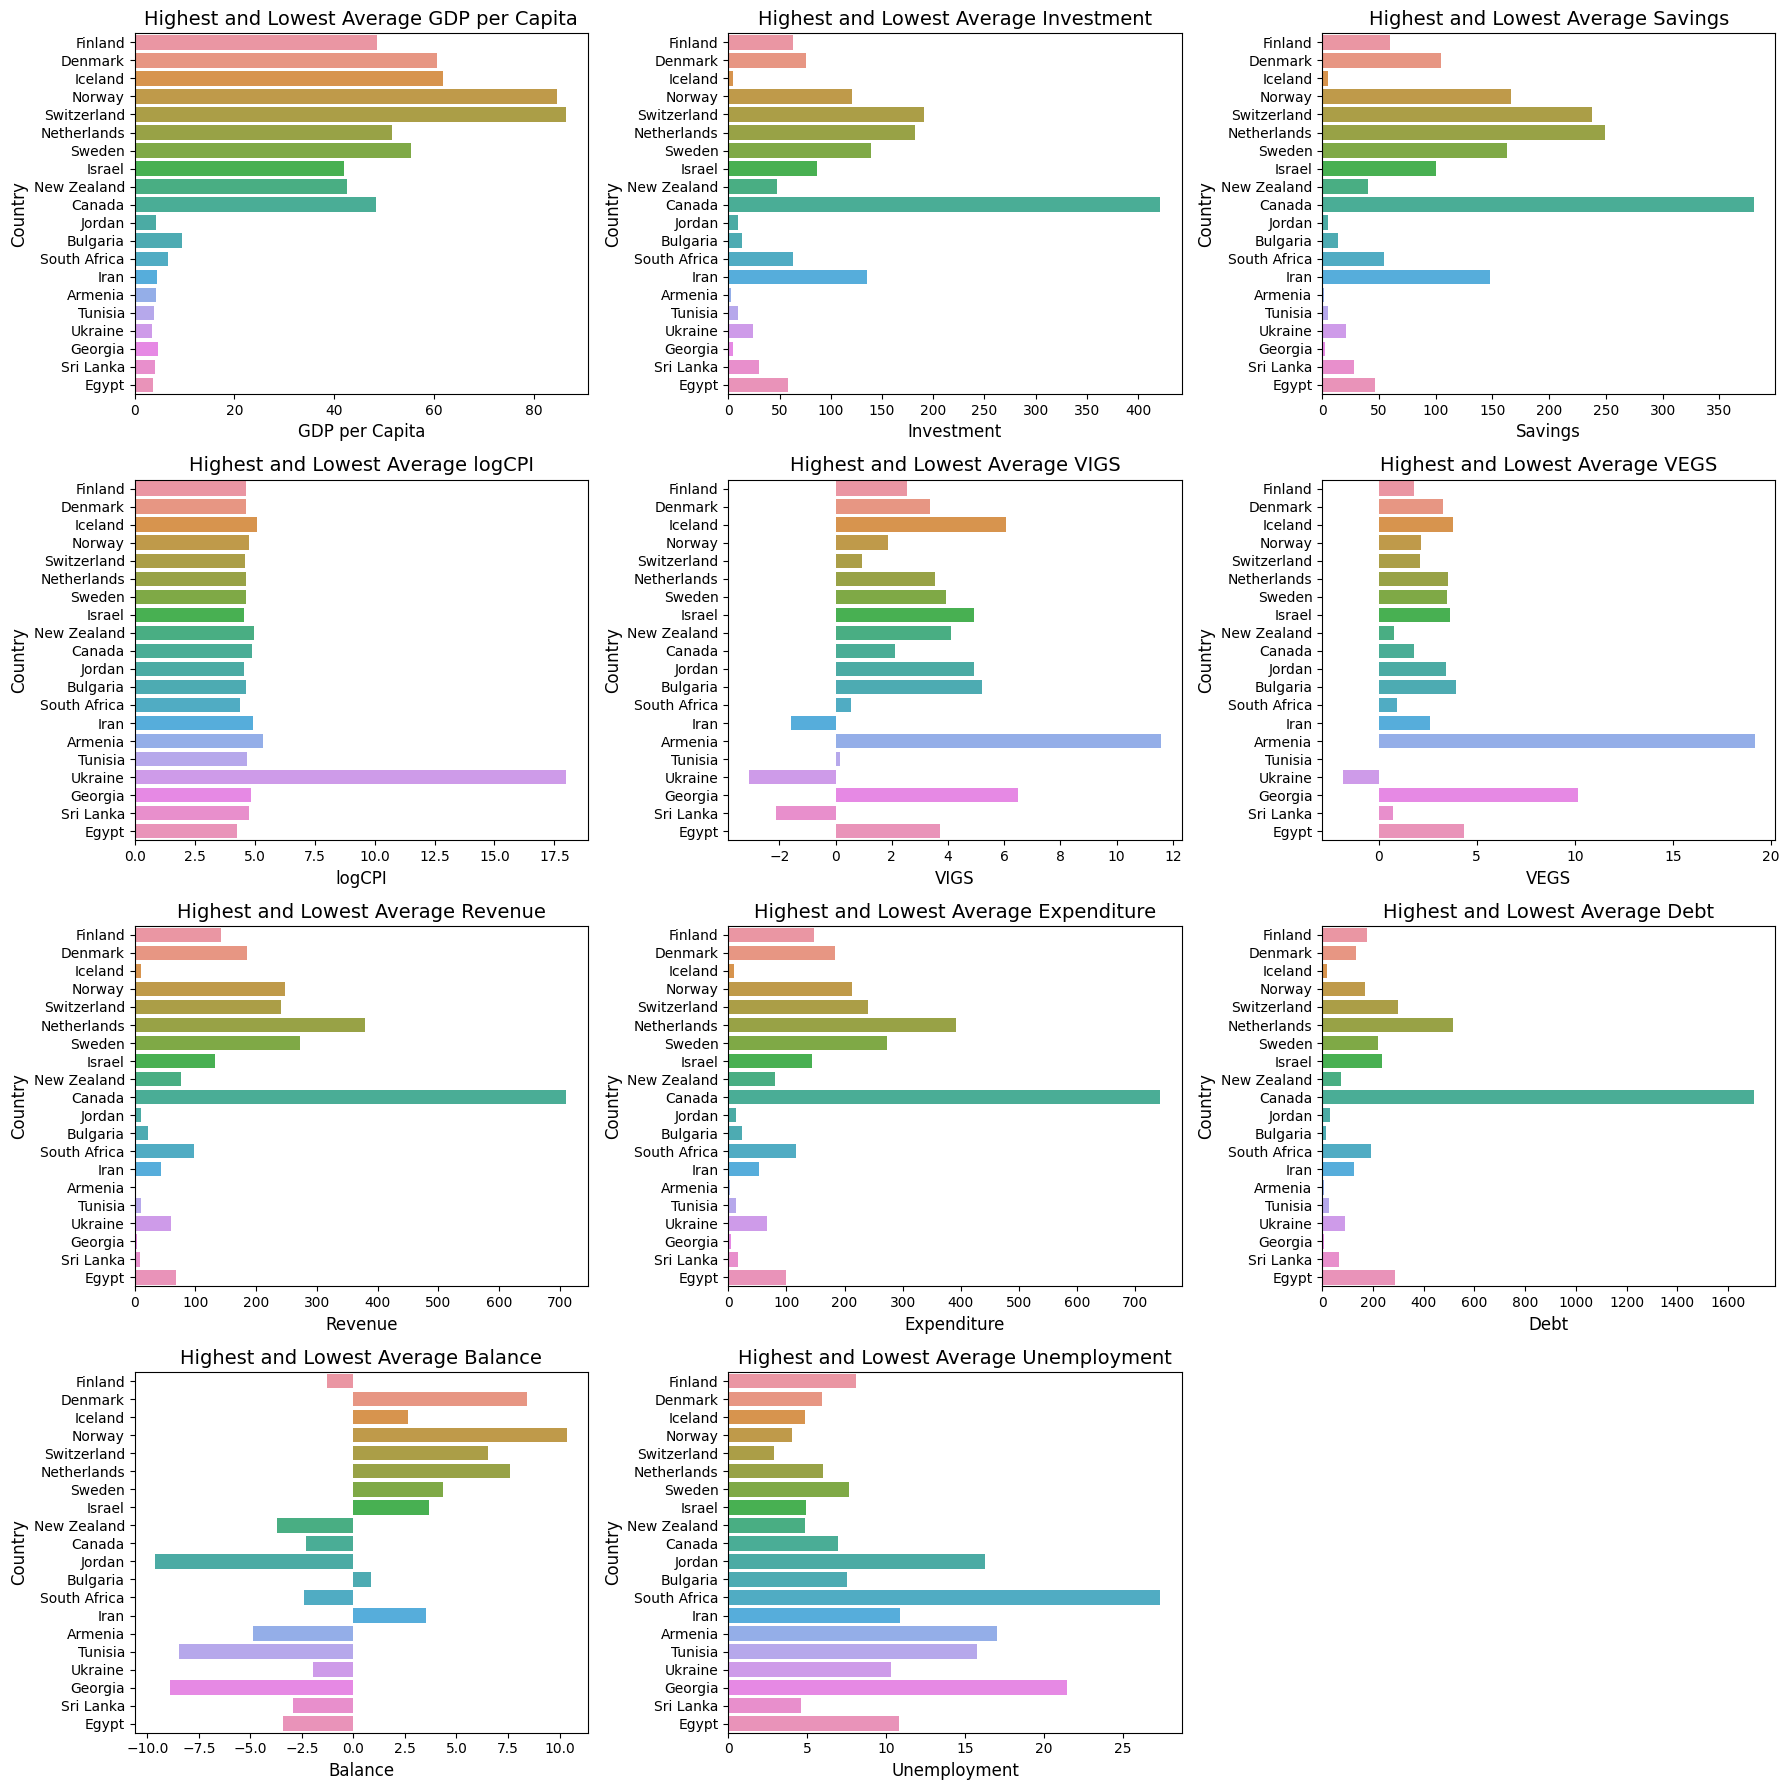

In [77]:
plt.figure(figsize=(18,18))

#subplot(nrows, ncols, index)
plt.subplot(4, 3, 1)
sns.barplot(x='GDP per Capita', y='Country', data=data_span_ranked)
plt.xlabel('GDP per Capita', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average GDP per Capita', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 2)
sns.barplot(x='Investment', y='Country', data=data_span_ranked)
plt.xlabel('Investment', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Investment', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 3)
sns.barplot(x='Savings', y='Country', data=data_span_ranked)
plt.xlabel('Savings', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Savings', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 4)
sns.barplot(x='logCPI', y='Country', data=data_span_ranked)
plt.xlabel('logCPI', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average logCPI', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 5)
sns.barplot(x='VIGS', y='Country', data=data_span_ranked)
plt.xlabel('VIGS', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average VIGS', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 6)
sns.barplot(x='VEGS', y='Country', data=data_span_ranked)
plt.xlabel('VEGS', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average VEGS', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 7)
sns.barplot(x='Revenue', y='Country', data=data_span_ranked)
plt.xlabel('Revenue', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Revenue', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 8)
sns.barplot(x='Expenditure', y='Country', data=data_span_ranked)
plt.xlabel('Expenditure', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Expenditure', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 9)
sns.barplot(x='Debt', y='Country', data=data_span_ranked)
plt.xlabel('Debt', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Debt', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 10)
sns.barplot(x='Balance', y='Country', data=data_span_ranked)
plt.xlabel('Balance', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Balance', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(4, 3, 11)
sns.barplot(x='Unemployment', y='Country', data=data_span_ranked)
plt.xlabel('Unemployment', fontsize=12);
plt.ylabel('Country', fontsize=12);
plt.title('Highest and Lowest Average Unemployment', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()

As suspected, the population ratio matters and in this case we can see more relation between happiness and GDP per capita.From these plots we can start to notice associations between happiness and GDP per capita, unemployment, balance, revenue. As well as some probabable association with expenditure, VEGS, and savings with some anomolies that should be explored.

We can more concretely see these correlations through bivariate analysis.

### Bivariate Approaches:

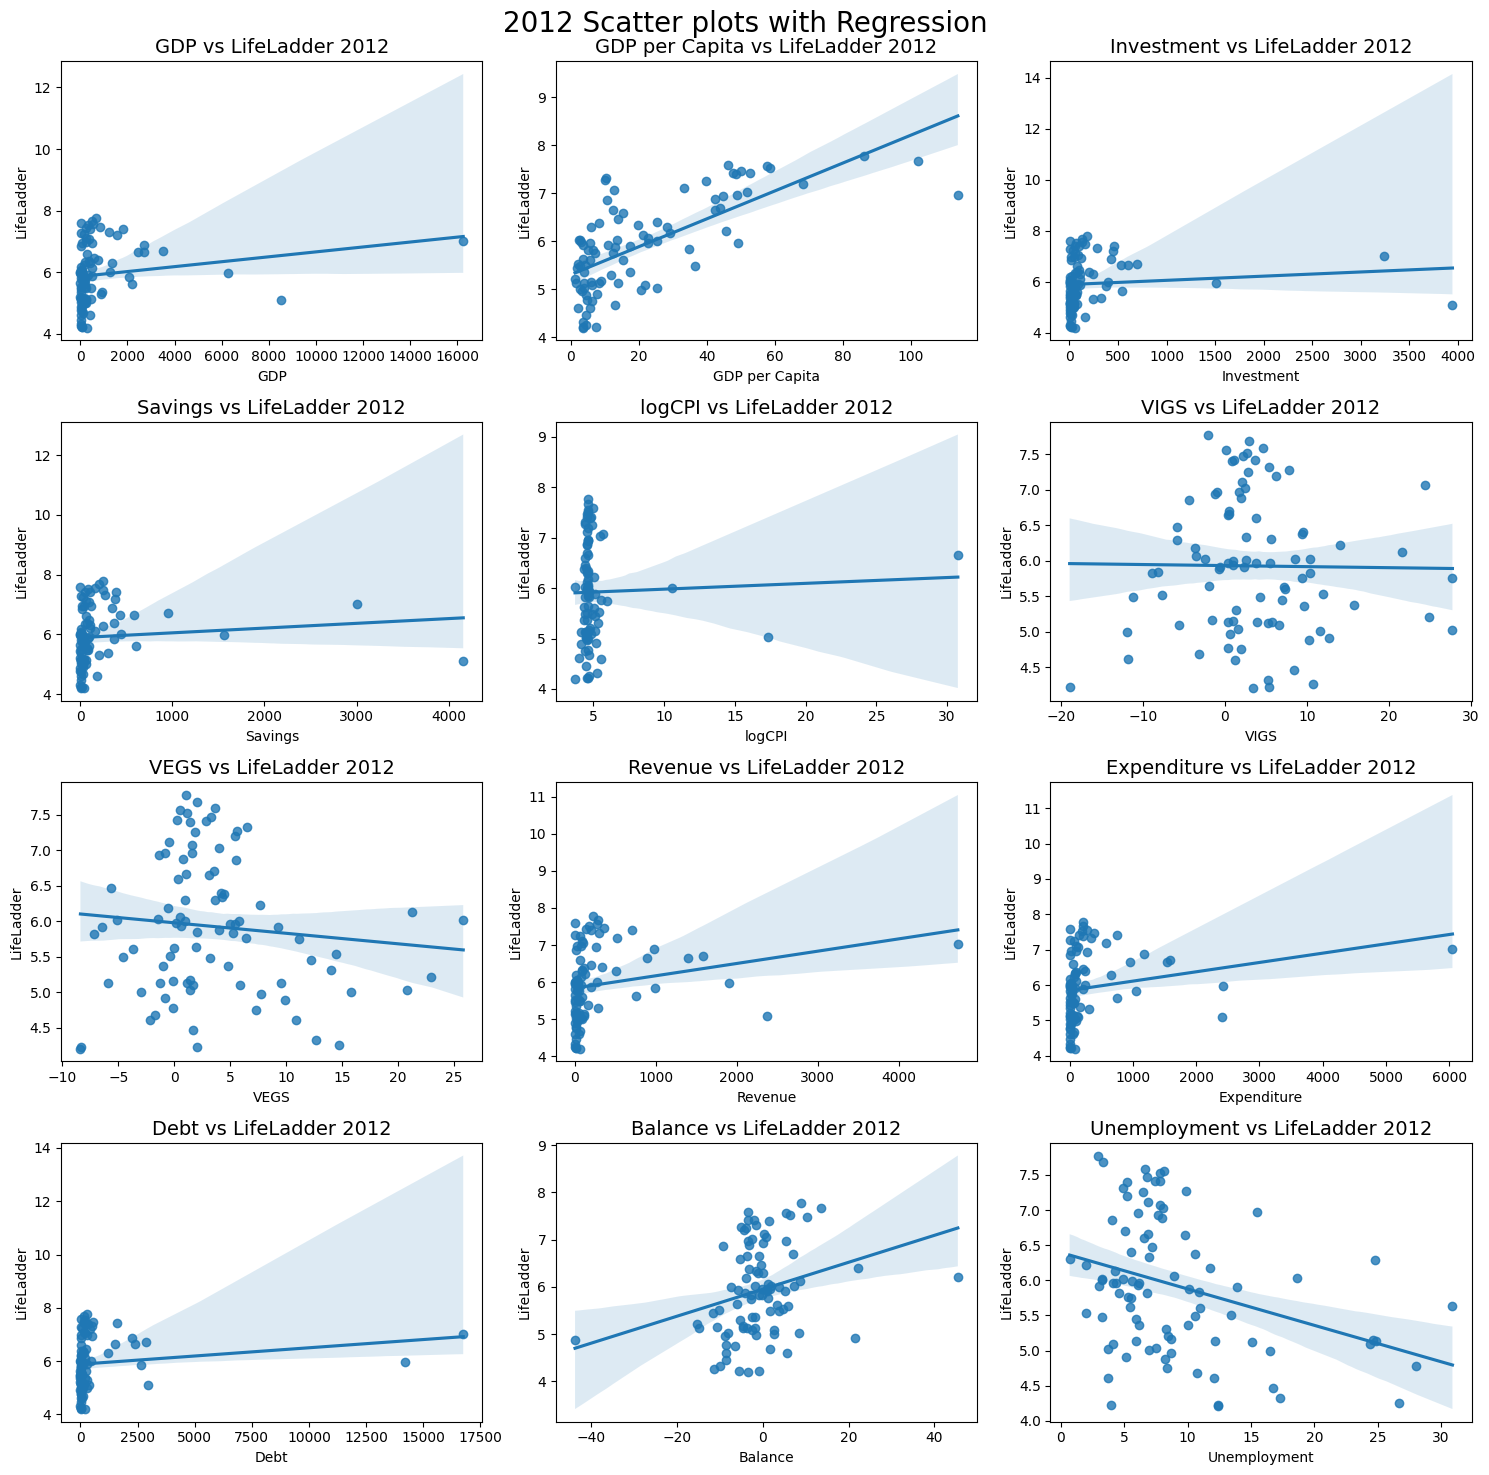

In [78]:
plt.figure(figsize=(15,15))

#subplot(nrows, ncols, index)
plt.subplot(4, 3, 1)
sns.regplot(data=data_2012_ranked, x='GDP', y='LifeLadder')
plt.suptitle('2012 Scatter plots with Regression', fontsize=20)
plt.title('GDP vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 2)
sns.regplot(data=data_2012_ranked, x='GDP per Capita', y='LifeLadder') 
plt.title('GDP per Capita vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 3)
sns.regplot(data=data_2012_ranked, x='Investment', y='LifeLadder') 
plt.title('Investment vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 4)
sns.regplot(data=data_2012_ranked, x='Savings', y='LifeLadder')
plt.title('Savings vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 5)
sns.regplot(data=data_2012_ranked, x='logCPI', y='LifeLadder')
plt.title('logCPI vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 6)
sns.regplot(data=data_2012_ranked, x='VIGS', y='LifeLadder')
plt.title('VIGS vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 7)
sns.regplot(data=data_2012_ranked, x='VEGS', y='LifeLadder')
plt.title('VEGS vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 8)
sns.regplot(data=data_2012_ranked, x='Revenue', y='LifeLadder')
plt.title('Revenue vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 9)
sns.regplot(data=data_2012_ranked, x='Expenditure', y='LifeLadder')
plt.title('Expenditure vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 10)
sns.regplot(data=data_2012_ranked, x='Debt', y='LifeLadder')
plt.title('Debt vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 11)
sns.regplot(data=data_2012_ranked, x='Balance', y='LifeLadder')
plt.title('Balance vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 12)
sns.regplot(data=data_2012_ranked, x='Unemployment', y='LifeLadder')
plt.title('Unemployment vs LifeLadder 2012', fontsize=14)

plt.show()

From these reggresion scatter plots we can confirm - for 2012 - that the strongest association with life ladder (happiness) is GDP per capita,furthermore we can note that our postulations from the univarite data is also correct. More specificaly we said that unemployment, balance, and savings have an  association with life ladder. We can also see more clearly the association with expenditure, VEGS, and revenue. Here VEGS and VIGS may have a plausable association, however, we can rule out expenditure and revenue.

Now we can explore the 10 year diffrence using 2022 data! 

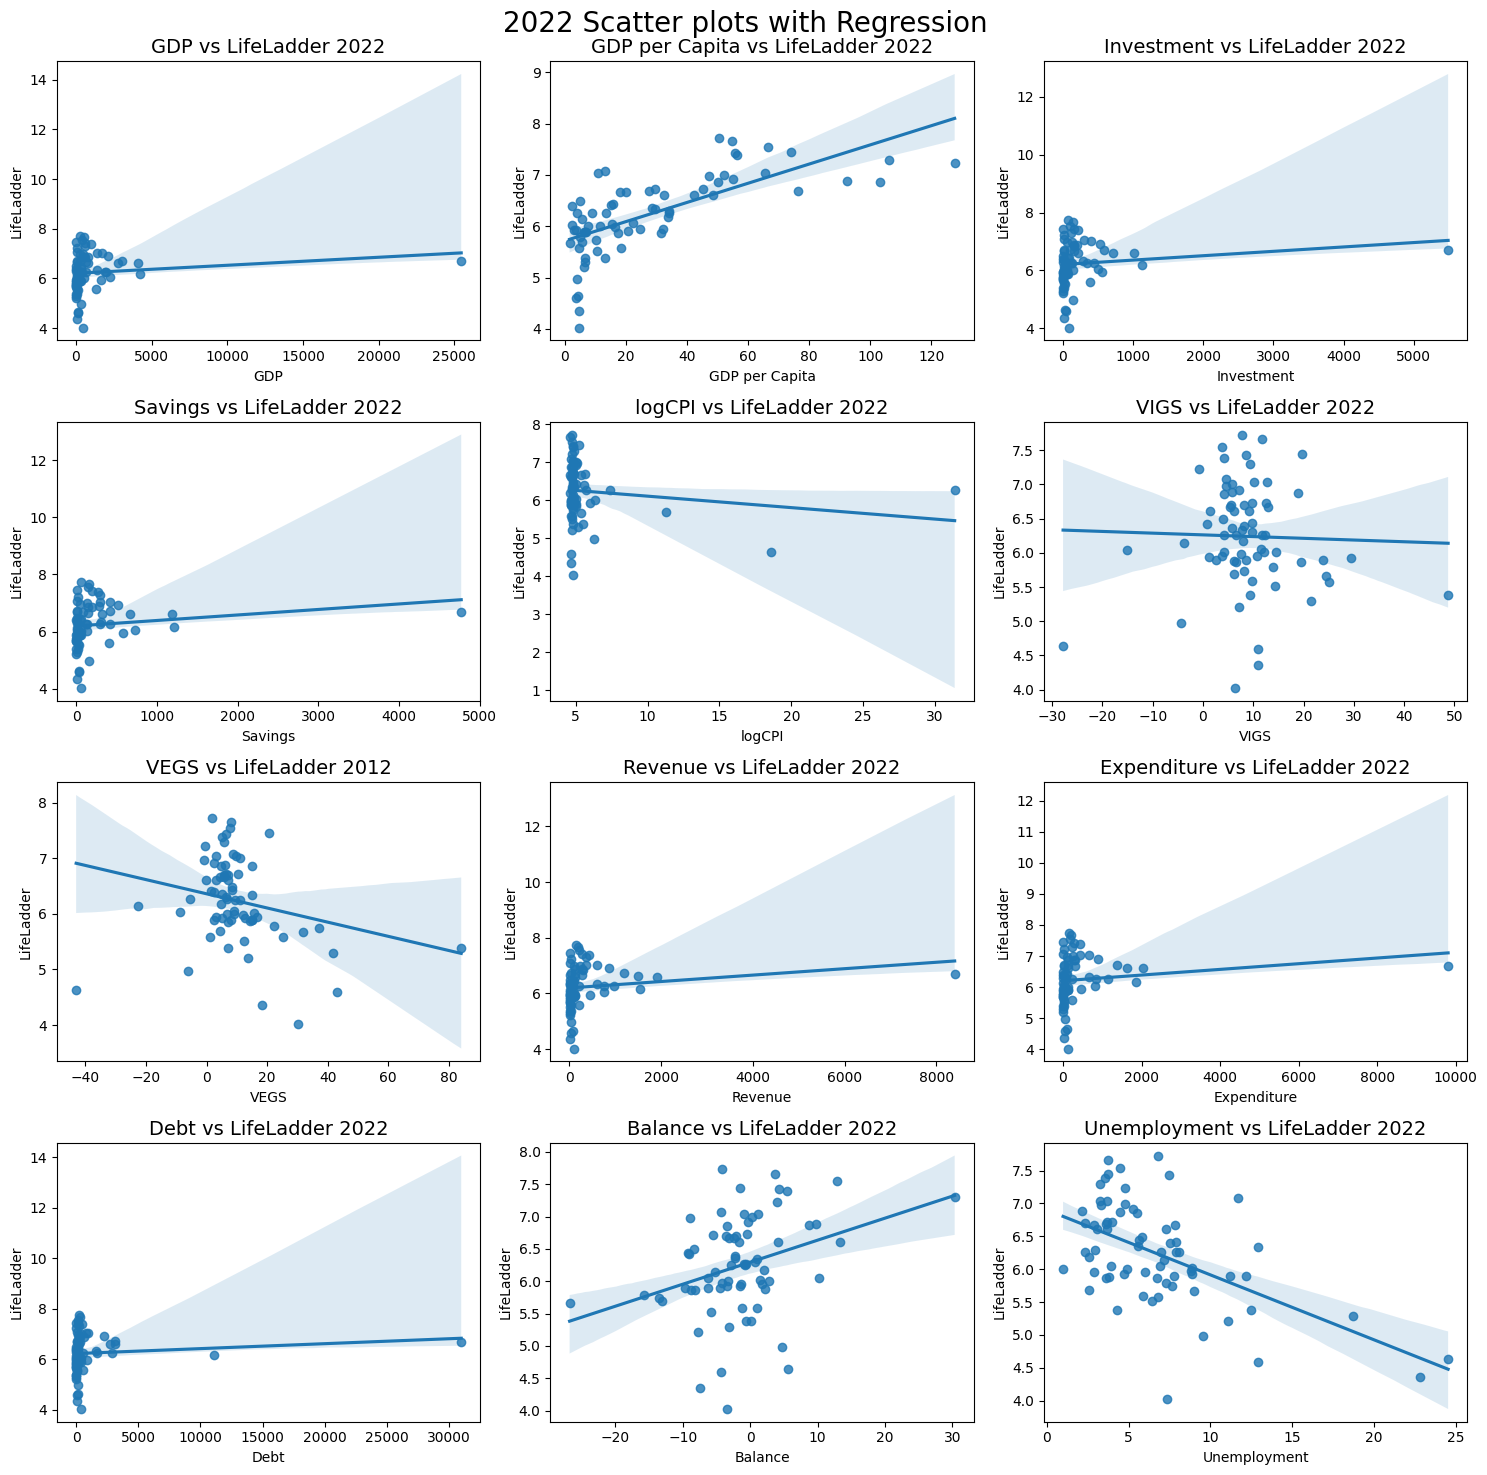

In [79]:
plt.figure(figsize=(15,15))

#subplot(nrows, ncols, index)
plt.subplot(4, 3, 1)
sns.regplot(data=data_2022_ranked, x='GDP', y='LifeLadder')
plt.suptitle('2022 Scatter plots with Regression', fontsize=20)
plt.title('GDP vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 2)
sns.regplot(data=data_2022_ranked, x='GDP per Capita', y='LifeLadder') 
plt.title('GDP per Capita vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 3)
sns.regplot(data=data_2022_ranked, x='Investment', y='LifeLadder') 
plt.title('Investment vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 4)
sns.regplot(data=data_2022_ranked, x='Savings', y='LifeLadder')
plt.title('Savings vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 5)
sns.regplot(data=data_2022_ranked, x='logCPI', y='LifeLadder')
plt.title('logCPI vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 6)
sns.regplot(data=data_2022_ranked, x='VIGS', y='LifeLadder')
plt.title('VIGS vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 7)
sns.regplot(data=data_2022_ranked, x='VEGS', y='LifeLadder')
plt.title('VEGS vs LifeLadder 2012', fontsize=14)

plt.subplot(4, 3, 8)
sns.regplot(data=data_2022_ranked, x='Revenue', y='LifeLadder')
plt.title('Revenue vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 9)
sns.regplot(data=data_2022_ranked, x='Expenditure', y='LifeLadder')
plt.title('Expenditure vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 10)
sns.regplot(data=data_2022_ranked, x='Debt', y='LifeLadder')
plt.title('Debt vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 11)
sns.regplot(data=data_2022_ranked, x='Balance', y='LifeLadder')
plt.title('Balance vs LifeLadder 2022', fontsize=14)

plt.subplot(4, 3, 12)
sns.regplot(data=data_2022_ranked, x='Unemployment', y='LifeLadder')
plt.title('Unemployment vs LifeLadder 2022', fontsize=14)

plt.show()

Here we see almost the same association relationships with the exception of VIGS and VEGS having much weaker assosiation. This thus requires more analysis. 

Text(0.5, 1.0, 'Correlation between variables and life ladder')

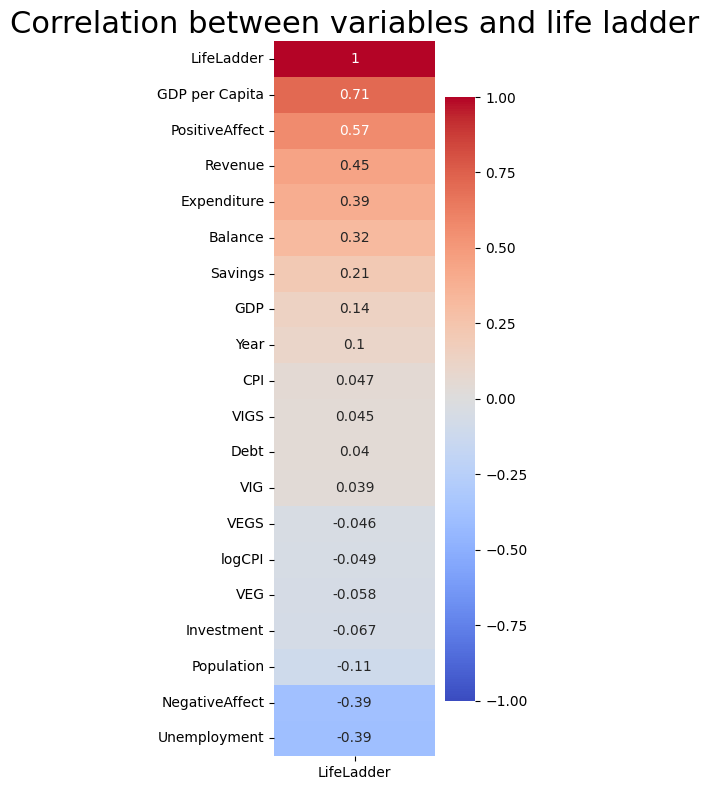

In [80]:
plt.figure(figsize=(4,8))
sns.heatmap(data.corr()[['LifeLadder']].sort_values('LifeLadder', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1);
plt.title('Correlation between variables and life ladder', fontsize=22)


Text(0.5, 1.0, 'Correlation between variables and average life ladder')

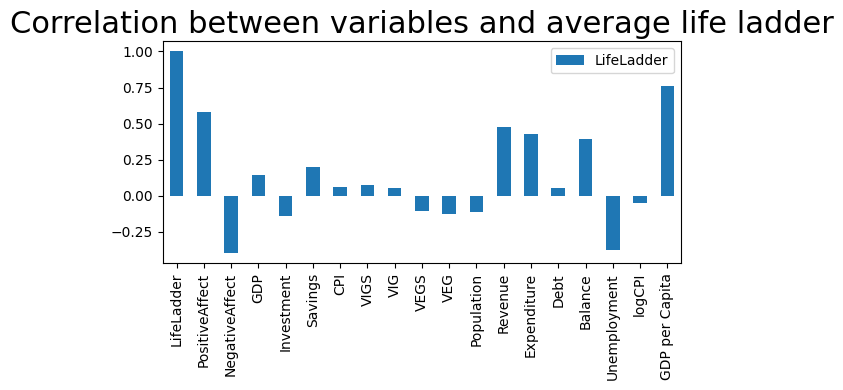

In [81]:
# Bar chart Visualisation 
data_span.corr()[['LifeLadder']].plot(kind='bar')
plt.title('Correlation between variables and average life ladder', fontsize=22)

Both these correlation graphs confirm our observations from above. 

Using the correlations from the regression plots and the heatmap, we can pick out the top 5 factors that have the most affect on happiness index. We can pick out the following factors:
* GDP per capita
* Revenue
* Expenditure
* Unemployment
* Balance
Let's look at the 10 year data for how each of the 5 variables correlate with life ladder (happiness score).

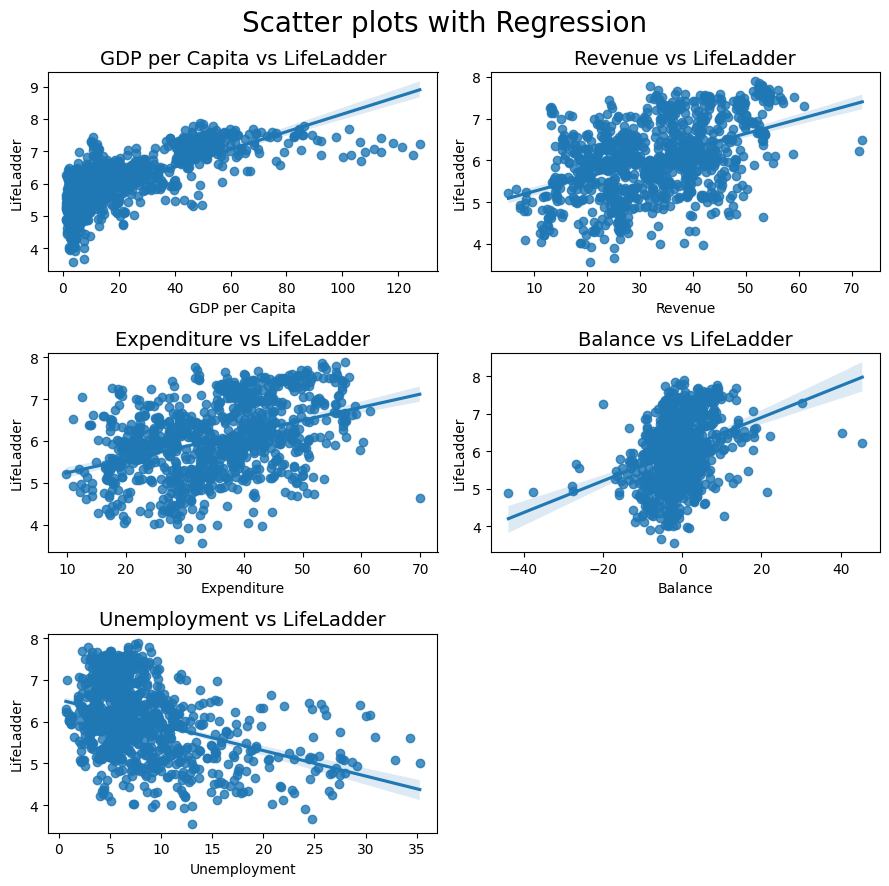

In [82]:
plt.figure(figsize=(9, 9))

#subplot(nrows, ncols, index)
plt.suptitle('Scatter plots with Regression', fontsize=20)

plt.subplot(3, 2, 1)
sns.regplot(data=data, x='GDP per Capita', y='LifeLadder') 
plt.title('GDP per Capita vs LifeLadder', fontsize=14)

plt.subplot(3, 2, 2)
sns.regplot(data=data, x='Revenue', y='LifeLadder')
plt.title('Revenue vs LifeLadder', fontsize=14)

plt.subplot(3, 2, 3)
sns.regplot(data=data, x='Expenditure', y='LifeLadder')
plt.title('Expenditure vs LifeLadder', fontsize=14)

plt.subplot(3, 2, 4)
sns.regplot(data=data, x='Balance', y='LifeLadder')
plt.title('Balance vs LifeLadder', fontsize=14)

plt.subplot(3, 2, 5)
sns.regplot(data=data, x='Unemployment', y='LifeLadder')
plt.title('Unemployment vs LifeLadder', fontsize=14)

plt.show()

GDP per capita evidently has the highest correlation with happiness index, but lets create a linear model for the top 3 factors (*GDP per capita*, *revenue*, and *expenditure*) from our initial analysis to see how they predict happiness.

In [83]:
gdp_happy = data[['GDP per Capita', 'LifeLadder']]

In [84]:
gdp_happy.columns = ['GDPperCapita', 'LifeLadder']

In [85]:
outcome, predictors = patsy.dmatrices('LifeLadder ~ GDPperCapita', gdp_happy)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

In [86]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             LifeLadder   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     978.6
Date:                Mon, 12 Jun 2023   Prob (F-statistic):          1.87e-148
Time:                        21:03:12   Log-Likelihood:                -895.67
No. Observations:                 957   AIC:                             1795.
Df Residuals:                     955   BIC:                             1805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.4242      0.028    195.993   

In [98]:
predicted_values = res.predict()  # predicted values
residual_values = res.resid # residual values

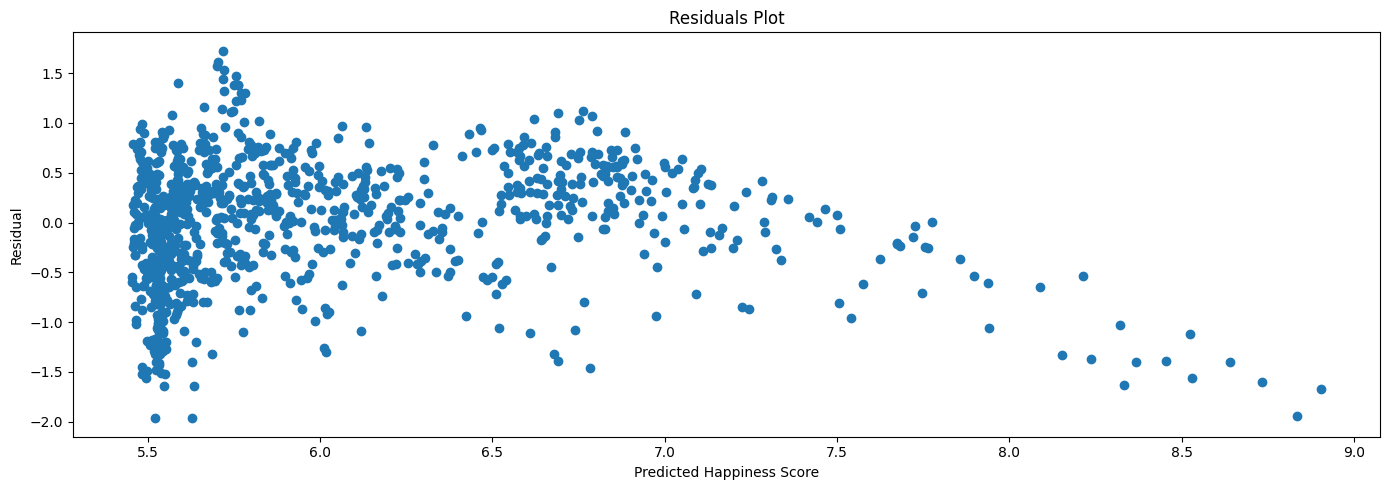

In [103]:
plt.scatter(predicted_values, residual_values)
plt.title("Residuals Plot")
plt.xlabel("Predicted Happiness Score")
plt.ylabel("Residual")
plt.show()


In [94]:
gdp_rev = data[['Revenue', 'LifeLadder']]
outcome1, predictors1 = patsy.dmatrices('LifeLadder ~ Revenue', gdp_rev)
mod1 = sm.OLS(outcome1, predictors1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:             LifeLadder   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     240.1
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           1.74e-48
Time:                        21:08:51   Log-Likelihood:                -1125.9
No. Observations:                 957   AIC:                             2256.
Df Residuals:                     955   BIC:                             2265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9146      0.076     64.710      0.0

In [95]:
gdp_exp = data[['Expenditure', 'LifeLadder']]
outcome2, predictors2 = patsy.dmatrices('LifeLadder ~ Expenditure', gdp_exp)
mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:             LifeLadder   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     172.6
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           2.34e-36
Time:                        21:09:43   Log-Likelihood:                -1153.7
No. Observations:                 957   AIC:                             2311.
Df Residuals:                     955   BIC:                             2321.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9285      0.087     56.402      

As seen in our comparison of linear models, *GDP per capita* had the highest R-squared value and had the most narrow confidence interval. Looking at R-squared value, however, only tells us there is a high correlation and the percentage of dependent variables that are explained by the predictor variable. The residuals plot above shows a pattern, which tells us that the regression model might not be a good fit for our data.

To get a better idea of how influential a variable was at predicting happiness index, we can look at a linear regression model that takes a linear combination of the variables; this way we see which variable is a strong and influential predictor of happiness.

In [105]:
data_np = data.drop(['Country', 'Year', 'PositiveAffect', 'NegativeAffect'], axis=1)

In [116]:
data_np.head()

,LifeLadder,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment,GDP per Capita,logCPI
0,5.5100,12.3240,29.8240,19.6740,94.7830,-7.6080,-5.1970,-0.4090,23.2340,2.9000,24.7890,28.2290,62.1440,-10.2020,13.4000,4.2497,4.5516
1,4.5510,12.7840,27.4910,16.8270,96.6080,-0.6170,-1.3100,8.2860,26.6850,2.8950,23.9770,29.1930,70.3910,-9.2530,15.9000,4.4159,4.5707
2,4.8140,13.2460,27.2880,13.3610,98.1670,5.4190,6.1140,3.3130,-6.2050,2.8890,26.2720,31.7290,71.9920,-10.7970,17.5000,4.5850,4.5867
3,4.6070,11.3890,26.2370,15.8040,100.0000,0.0720,2.1610,5.2540,4.2920,2.8810,26.4400,30.7580,73.7160,-8.6090,17.1000,3.9531,4.6052
4,4.5110,11.8620,25.4700,16.7960,101.2870,8.2690,9.3850,10.3160,-0.5730,2.8760,27.6420,29.1390,73.3240,-7.5720,15.2000,4.1245,4.6180


In [113]:
data_arr = np.array(data_np)
x = [x[1:] for x in data_arr]
y = [y[:1] for y in data_arr]

In [127]:
clf = Lasso(alpha=0.4)
clf.fit(x, y)
coeff = clf.coef_
print(coeff)
importance = np.abs(coeff)
print(importance)

[ 2.09607250e-05 -0.00000000e+00  0.00000000e+00  2.36822262e-14
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -6.41931405e-04  0.00000000e+00  1.00021113e-02 -2.01876980e-03
  0.00000000e+00 -2.32149807e-02  2.28132626e-02 -0.00000000e+00]
[2.09607250e-05 0.00000000e+00 0.00000000e+00 2.36822262e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.41931405e-04 0.00000000e+00 1.00021113e-02 2.01876980e-03
 0.00000000e+00 2.32149807e-02 2.28132626e-02 0.00000000e+00]


Using the Lasso model of linear regression, we used a linear model to look at happiness score as a linear combination of the 16 variables. Specifically, we wanted to see the coefficients of the various predictor variables to see which variables were influential in the prediction of happiness score. Using Lasso regression, we fit a model with the dependent and independent variables, also setting an alpha value of 0.4 to enforce a more restrictive feature selection and to have the output coefficients be the ones that are most influential to predicting happiness. 

After getting the coefficients, we looked at the absolute value of the coefficients. The highest (top 4) coefficients belonged to variables *CPI* at 2.368, *Population* at 6.419, *Unemployment* at 2.321, and *GDP per capita* at 2.281. This tells us that these 4 predictors were weighted more in our regression model and played an important role in predicting happiness. Cross referencing our results with previous univariate analysis, we see that *GDP per capita* appeared in both results. 

### More Analysis with GDP
Although we found GDP per Capita to be more usefull above, there is still some analysis we can do using GDP!

[Text(0.5, 1.0, 'Life Ladder vs GDP > 5000')]

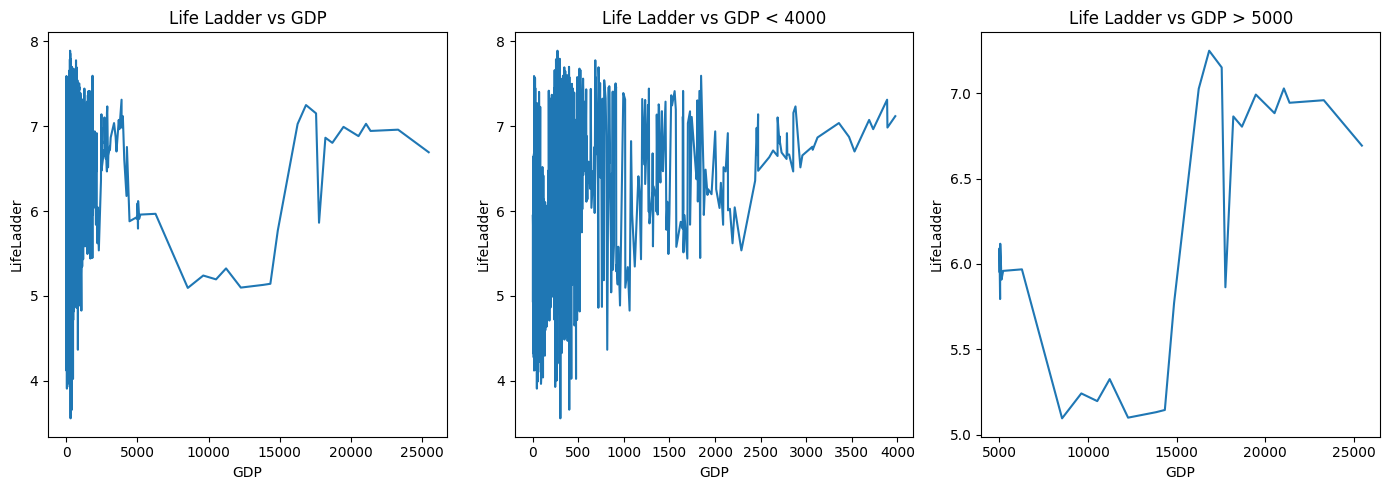

In [87]:
plt.rcParams["figure.figsize"] = [14.00, 5.00]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(1, 3)
sns.lineplot(x = "GDP", y = "LifeLadder", data = data, ax = axes[0]).set(title = "Life Ladder vs GDP")
sns.lineplot(x = "GDP", y = "LifeLadder", data = data[data['GDP']<4000], ax = axes[1]).set(title = "Life Ladder vs GDP < 4000")
sns.lineplot(x = "GDP", y = "LifeLadder", data = data[data['GDP']>5000], ax = axes[2]).set(title = "Life Ladder vs GDP > 5000")

We see that the Life Ladder score fluctuates for GDP under ~5000 and shows the furthest right trend for GDP over 5000.

[Text(0.5, 1.0, 'Life Ladder vs logCPI > 10')]

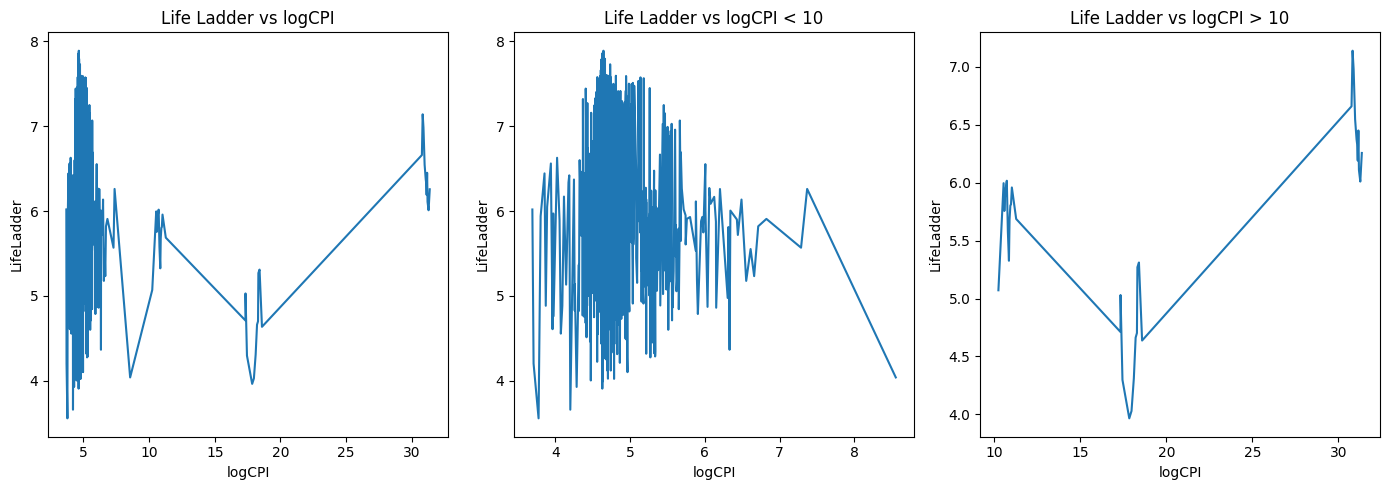

In [88]:
pd.options.display.float_format = '{:.4f}'.format

f, axes = plt.subplots(1, 3)
sns.lineplot(x = "logCPI", y = "LifeLadder", data = data, ax = axes[0]).set(title = "Life Ladder vs logCPI")
sns.lineplot(x = "logCPI", y = "LifeLadder", data = data[data['logCPI'] < 10], ax = axes[1]).set(title = "Life Ladder vs logCPI < 10")
sns.lineplot(x = "logCPI", y = "LifeLadder", data = data[data['logCPI'] > 10], ax = axes[2]).set(title = "Life Ladder vs logCPI > 10")

We see some similar trends with logCPI against Life Ladder with a dip ~7.5 and fluctuation under logCPI ~7.5. The right most trend is shown for logCPI > 10.

### Extra peice of exploration - working with geospatial data:
Here we wanted to experiment with geopandas to great a world heat map of the life ladder to analyze on a global scale.

In [89]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0000,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0000,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0000,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0000,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0000,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [90]:
table = world.merge(data_span, how="left", left_on=['name'], right_on=['Country'])

In [91]:
table = table.dropna()

In [92]:
# Create a map
my_map = folium.Map()
# Add the data
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['Country', 'LifeLadder'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Happiness across the world'
).add_to(my_map)
my_map.save('happy.html')

happy.html is an html file with our world map as displayed below. We couldn't figure out how to display the html file on github so we added a picture here and then included the file in our repo. 

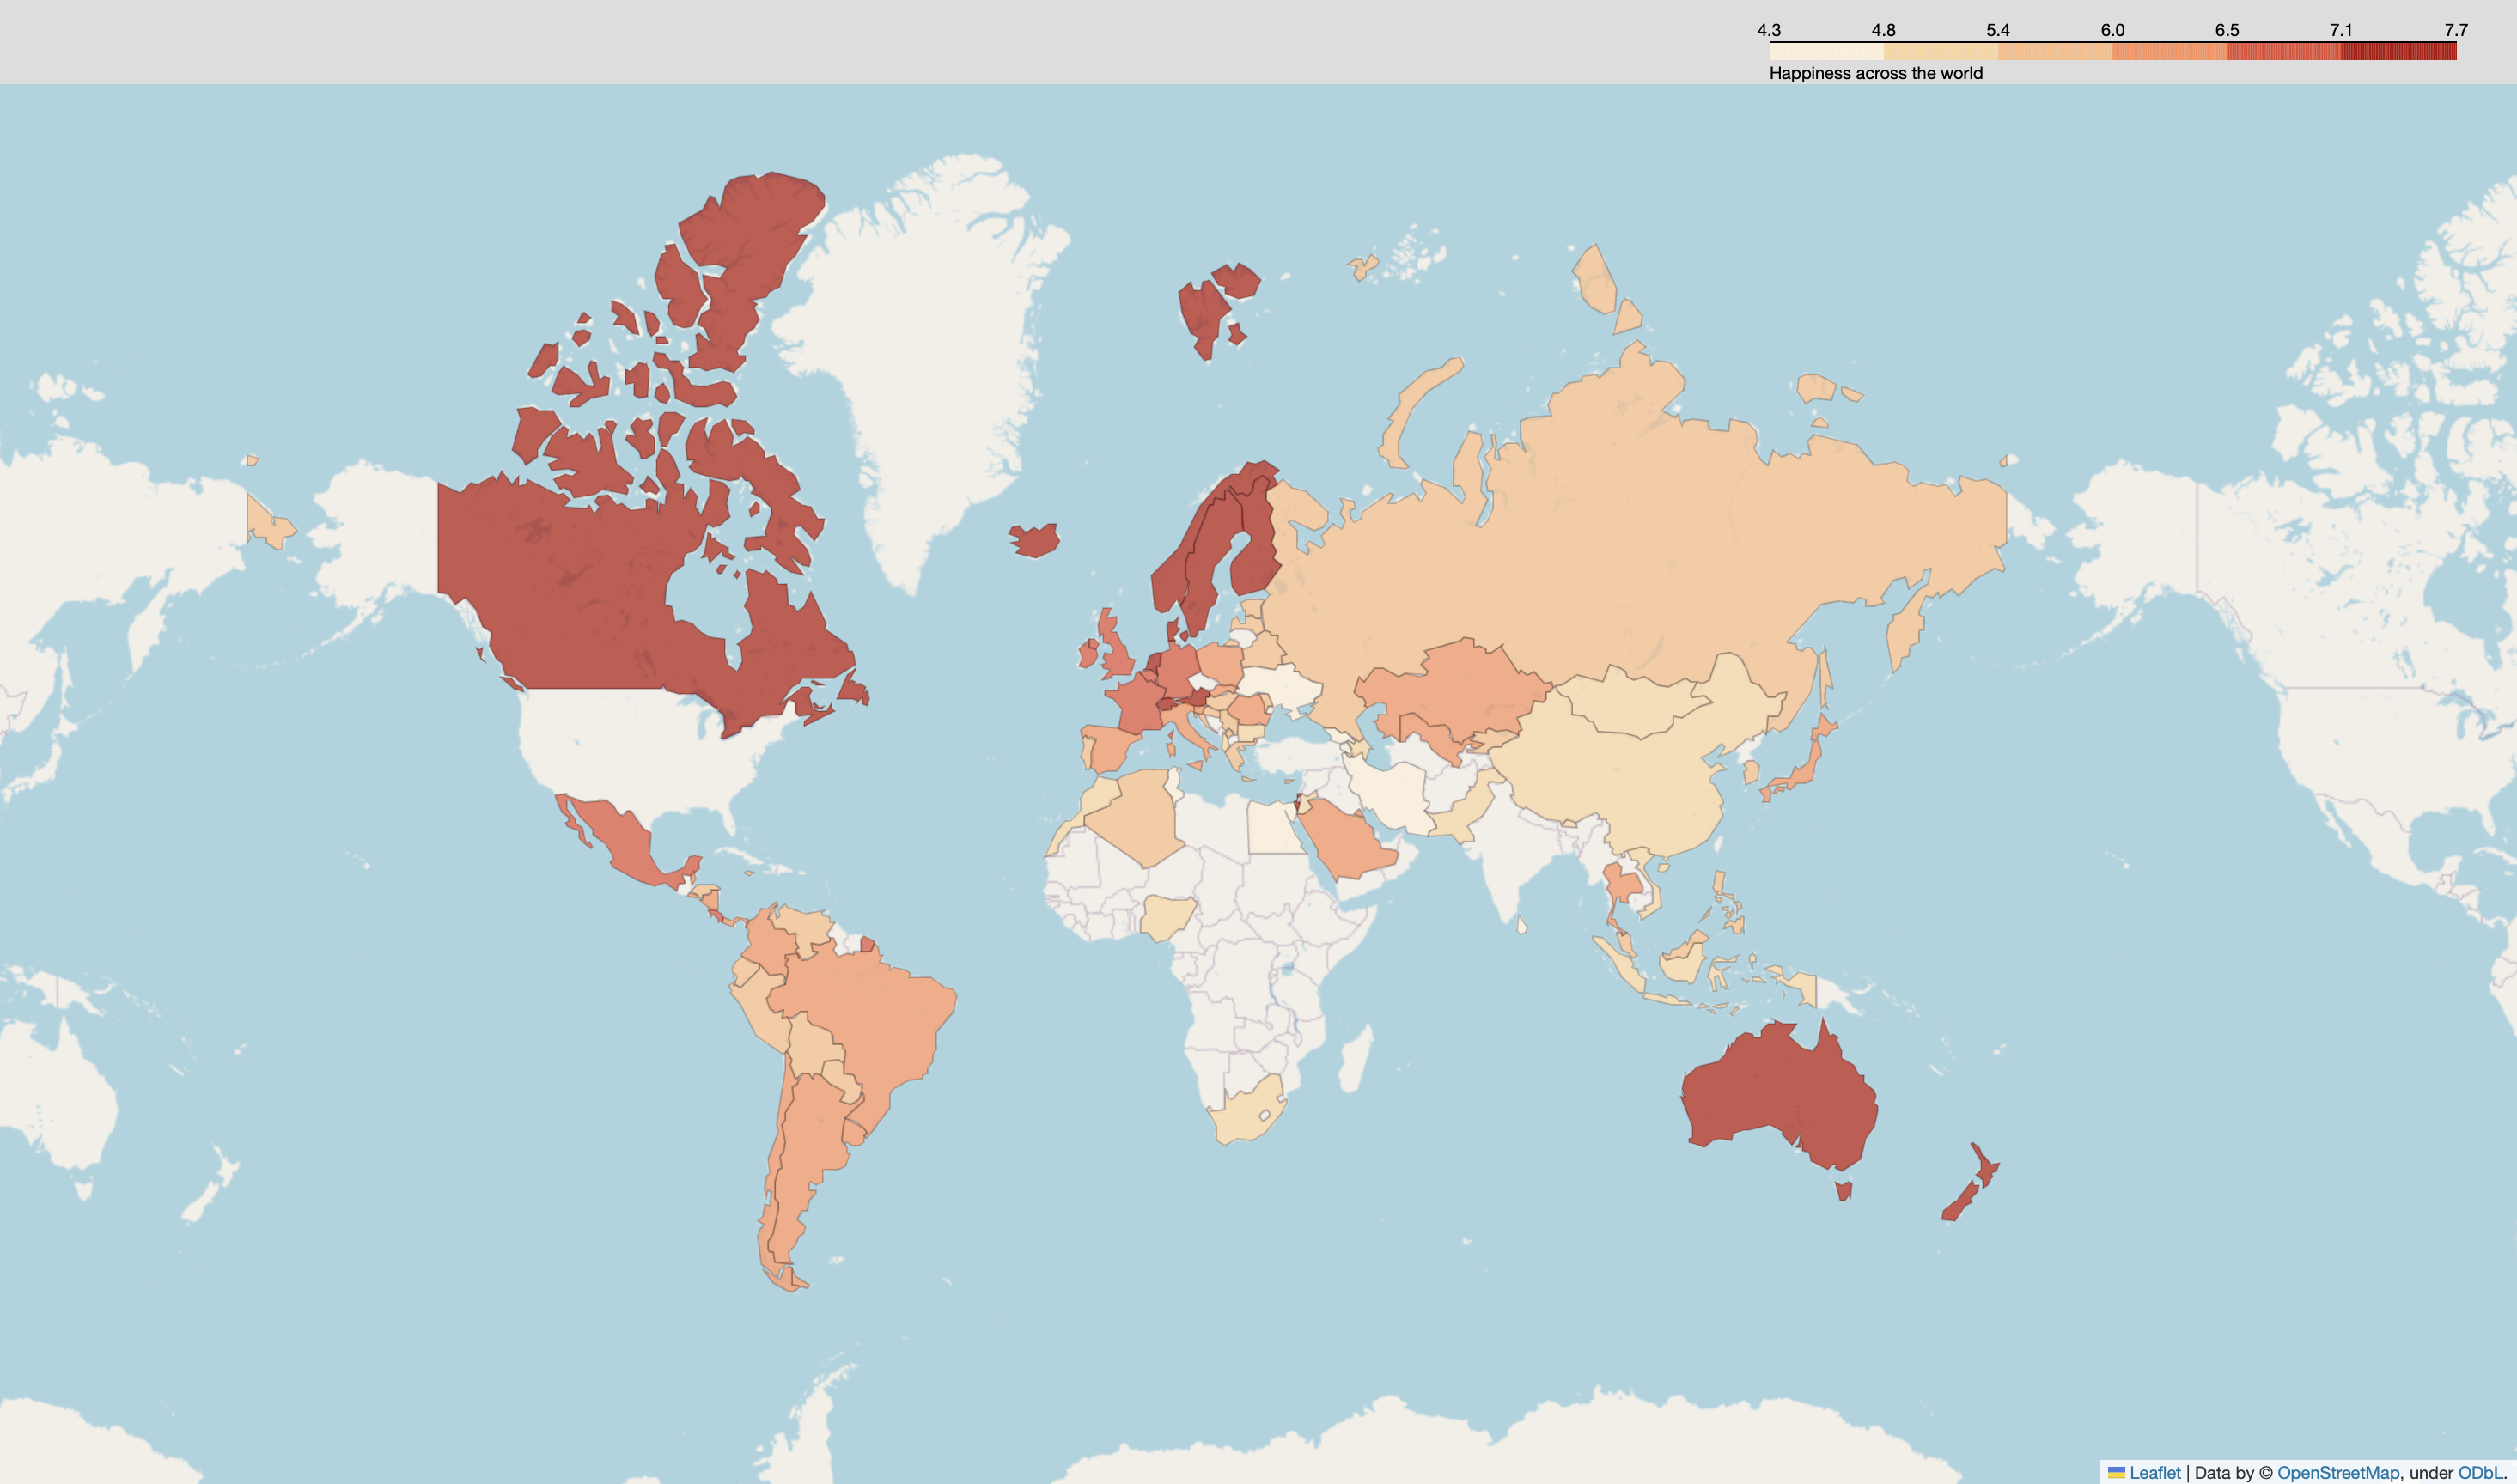

In [93]:
Image("Happy global.png")